In [2]:
# [ python 3.12 ]
# !conda create -n ai_env python=3.12 -y
# !conda activate ai_env

In [3]:
# !pip install numpy pandas matplotlib seaborn -q

In [4]:
# !pip install ipykernel scikit-learn tqdm -q

In [5]:
# !pip install statsmodels -q

In [6]:
#### linux 버전 확인용
# !pip install distro -q

In [7]:
# #!pip install scikit-optimize -q
# !pip install 'scikit-optimize[plots]' -q # plot functionality

In [ ]:
# !pip install optuna -q
# !pip install plotly -q
! pip install nbformat -q

## 1. Import

In [9]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

In [10]:
from sklearn import datasets, ensemble # sklearn tree models

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# 한글 폰트 설정
import matplotlib
import matplotlib.font_manager as fm
import platform

# OS 정보
os_name = platform.system()         # Windows / Linux / Darwin
os_version = platform.release()     # 11, 8.1, 22.04 등은 직접 매핑 필요

"""
OS	            NT 버전 (platform.version()의 major.minor 부분)	대표 빌드 번호
Windows 8.0	    6.2	                                            9200
Windows 8.1	    6.3	                                            9600
Windows 10	    10.0	                                        10240 ~ 19045
Windows 11	    10.0	                                        22000 / 22621 / 22631 / 26100
""" 

# C:\Windows\Fonts   # ==> Windows OS에 등록되어 있는 모든 폰트 파일들
if os_name == "Windows":
    # Windows 11 / Windows 8.1 구분하기
    # platform.release()가 10으로 나오는 경우도 있어 version() 검사 필요
    version_detail = platform.version()

    if "10.0" in version_detail:
        # Windows 11 or Windows 10 버전: 10.0
        print("→ Windows 11 (or 10) detected")
        font_path = 'C:\\Windows\\Fonts\\H2GTRM.TTF' # 윈도우 OS, Windows11 폰트 경로

    elif "6.3" in version_detail:
        # Windows 8.1 버전: 6.3
        print("→ Windows 8.1 detected")
        font_path = 'C:\\Windows\\Fonts\\batang.ttc' # 윈도우 OS, Windows8.1 폰트 경로

    else:
        print("→ Unknown Windows version:", version_detail)
        
# '~/.local/share/fonts/' or '/usr/share/fonts/opentype/noto/NotoSerifCJK-Regular.ttc' # Ubuntu 22.04 폰트 경로
elif os_name == "Linux":
    # Ubuntu 버전 확인
    import distro   # pip install distro (필요 시)

    linux_name = distro.name()
    linux_version = distro.version()

    if linux_name == "Ubuntu" and linux_version.startswith("22.04"):
        print("→ Ubuntu 22.04 detected")
        font_path = '/home/yypark/.local/share/fonts/D2Coding-Ver1.3.2-20180524.ttf' # Ubuntu 22.04 폰트 경로
    else:
        print(f"→ Other Linux distro: {linux_name} {linux_version}")
        font_path = '/usr/share/fonts/opentype/noto/NotoSerifCJK-Regular.ttc' # Ubuntu 폰트 경로

else:
    print("Unsupported OS:", os_name)
    

font_prop = fm.FontProperties(fname = font_path) # 폰트경로에 있는 폰트 이름들 뽑아오자.
font_name = font_prop.get_name() # 폰트명

#matplotlib.rc('font', key=value)
matplotlib.rc('font', family=font_name)

# matplotlib이 기본적으로 사용하는 유니코드 마이너스 비활성화
# -> 아스키코드의 마이너스 사용
plt.rc('axes', unicode_minus=False) # matplotlib의 기본적인 유니코드 minus폰트사용 중지

→ Ubuntu 22.04 detected


In [13]:
def safe_corr(x, y):
    """_summary_

    Args:
        x (_type_): _description_
        y (_type_): _description_

    Returns:
        _type_: _description_
    """
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return float(np.corrcoef(x, y)[0, 1])

def find_comovement_pairs(pivot, max_lag=6, min_nonzero=12, corr_threshold=0.4):
    """_summary_
    - 각 (A, B) 쌍에 대해 lag = 1 ~ max_lag까지 Pearson 상관계수 계산
    - 절댓값이 가장 큰 상관계수와 lag를 선택
    - |corr| >= corr_threshold이면 A→B 공행성 있다고 판단
    Args:
        pivot (_type_): _description_
        max_lag (int, optional): _description_. Defaults to 6.
        min_nonzero (int, optional): _description_. Defaults to 12.
        corr_threshold (float, optional): _description_. Defaults to 0.4.

    Returns:
        _type_: _description_
    """
    items = pivot.index.to_list()
    months = pivot.columns.to_list()
    n_months = len(months)

    results = []

    for i, leader in tqdm(enumerate(items)):
        x = pivot.loc[leader].values.astype(float)
        if np.count_nonzero(x) < min_nonzero:
            continue

        for follower in items:
            if follower == leader:
                continue

            y = pivot.loc[follower].values.astype(float)
            if np.count_nonzero(y) < min_nonzero:
                continue

            best_lag = None
            best_corr = 0.0

            # lag = 1 ~ max_lag 탐색
            for lag in range(1, max_lag + 1):
                if n_months <= lag:
                    continue
                corr = safe_corr(x[:-lag], y[lag:])
                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag

            # 임계값 이상이면 공행성쌍으로 채택
            if best_lag is not None and abs(best_corr) >= corr_threshold:
                results.append({
                    "leading_item_id": leader,
                    "following_item_id": follower,
                    "best_lag": best_lag,
                    "max_corr": best_corr,
                })

    pairs = pd.DataFrame(results)
    return pairs



In [14]:
#####  기본값: find_comovement_pairs_mod(pivot, max_lag=6, min_lag = 1, min_nonzero=12, corr_threshold=0.4)
def find_comovement_pairs_mod(pivot, max_lag=6, min_lag = 1, min_nonzero=12, corr_threshold=0.4):
    """_summary_
    - 각 (A, B) 쌍에 대해 lag = 0 ~ max_lag까지 Pearson 상관계수 계산
    - 절댓값이 가장 큰 상관계수와 lag를 선택
    - |corr| >= corr_threshold이면 A→B 공행성 있다고 판단
    Args:
        pivot (_type_): _description_
        max_lag (int, optional): _description_. Defaults to 6.
        min_lag (int, optional): _description_. Defaults to 1.
        min_nonzero (int, optional): _description_. Defaults to 12.
        corr_threshold (float, optional): _description_. Defaults to 0.4.

    Returns:
        _type_: _description_
    """
    items = pivot.index.to_list()
    months = pivot.columns.to_list()
    n_months = len(months)

    results = []

    for i, leader in tqdm(enumerate(items)):
        x = pivot.loc[leader].values.astype(float)
        if np.count_nonzero(x) < min_nonzero:
            continue

        for follower in items:
            if follower == leader:
                continue

            y = pivot.loc[follower].values.astype(float)
            if np.count_nonzero(y) < min_nonzero:
                continue

            best_lag = None
            best_corr = 0.0

            ## lag = 1 ~ max_lag 탐색
            #for lag in range(1, max_lag + 1):
            # lag = 0 ~ max_lag 탐색
            for lag in range(min_lag, max_lag + 1):
                if n_months <= lag:
                    continue
                if lag == 0: corr = safe_corr(x[:], y[lag:])
                else: corr = safe_corr(x[:-lag], y[lag:])
                
                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag

            # 임계값 이상이면 공행성쌍으로 채택
            if best_lag is not None and abs(best_corr) >= corr_threshold:
                results.append({
                    "leading_item_id": leader,
                    "following_item_id": follower,
                    "best_lag": best_lag,
                    "max_corr": best_corr,
                })

    pairs = pd.DataFrame(results)
    return pairs


In [15]:

def find_comovement_pairs_diff(pivot, max_lag=6, min_nonzero=12, corr_threshold=0.4):
    items = pivot.index.to_list()
    months = pivot.columns.to_list()
    n_months = len(months)

    results = []

    for i, leader in tqdm(enumerate(items)):
        #x = pivot.loc[leader].values.astype(float)
        x_raw = pivot.loc[leader].values.astype(float)
        if np.count_nonzero(x_raw) < min_nonzero:
            continue

        x = np.diff(x_raw) # 변화량, 1차분
        for follower in items:
            if follower == leader:
                continue

            #y = pivot.loc[follower].values.astype(float)
            y_raw = pivot.loc[follower].values.astype(float)
            if np.count_nonzero(y_raw) < min_nonzero:
                continue
            
            y = np.diff(y_raw) # 변화량, 1차분

            best_lag = None
            best_corr = 0.0

            # lag = 1 ~ max_lag 탐색
            for lag in range(1, max_lag + 1):
                if (n_months-1) <= lag: # diff로 데이터 1개 줄어서 n_months-1 (43 -> 42)
                    continue
                
                # x_diff[:-lag], y_diff[lag:] 비교
                corr = safe_corr(x[:-lag], y[lag:])
                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag

            # 임계값 이상이면 공행성쌍으로 채택
            if best_lag is not None and abs(best_corr) >= corr_threshold:
                results.append({
                    "leading_item_id": leader,
                    "following_item_id": follower,
                    "best_lag": best_lag,
                    "max_corr": best_corr,
                })

    pairs = pd.DataFrame(results)
    return pairs

# pairs_diff = find_comovement_pairs_diff(pivot)
# print("탐색된 공행성쌍 수:", len(pairs_diff)) 
# pairs_diff.head()

In [16]:
#####  기본값: find_comovement_pairs_mod(pivot, max_lag=6, min_lag = 1, min_nonzero=12, corr_threshold=0.4)
def find_comovement_pairs_mod_diff(pivot, max_lag=6, min_lag = 1, min_nonzero=12, corr_threshold=0.4):
    """_summary_
    - 각 (A, B) 쌍에 대해 lag = 0 ~ max_lag까지 Pearson 상관계수 계산
    - 절댓값이 가장 큰 상관계수와 lag를 선택
    - |corr| >= corr_threshold이면 A→B 공행성 있다고 판단
    Args:
        pivot (_type_): _description_
        max_lag (int, optional): _description_. Defaults to 6.
        min_lag (int, optional): _description_. Defaults to 1.
        min_nonzero (int, optional): _description_. Defaults to 12.
        corr_threshold (float, optional): _description_. Defaults to 0.4.

    Returns:
        _type_: _description_
    """
    items = pivot.index.to_list()
    months = pivot.columns.to_list()
    n_months = len(months)

    results = []

    for i, leader in tqdm(enumerate(items)):
        # x = pivot.loc[leader].values.astype(float)
        x_raw = pivot.loc[leader].values.astype(float)
        if np.count_nonzero(x_raw) < min_nonzero:
            continue

        x = np.diff(x_raw) # 변화량 1차분 계산, 데이터 1개 줄어듦
        for follower in items:
            if follower == leader:
                continue

            # y = pivot.loc[follower].values.astype(float)
            y_raw = pivot.loc[follower].values.astype(float)
            if np.count_nonzero(y_raw) < min_nonzero:
                continue

            y = np.diff(y_raw) # 변화량 1차분 계산, 데이터 1개 줄어듦
            best_lag = None
            best_corr = 0.0

            ## lag = 1 ~ max_lag 탐색
            #for lag in range(1, max_lag + 1):
            # lag = 0 ~ max_lag 탐색
            for lag in range(min_lag, max_lag + 1):
                # if n_months <= lag:
                if (n_months-1) <= lag: # 데이터 1개 줄어서 n_months-1(43 -> 42)
                    continue

                # x_diff[:-lag] 와 y_diff[lag:] 비교
                if lag == 0: corr = safe_corr(x[:], y[lag:])
                else: corr = safe_corr(x[:-lag], y[lag:])
                
                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag

            # 임계값 이상이면 공행성쌍으로 채택
            if best_lag is not None and abs(best_corr) >= corr_threshold:
                results.append({
                    "leading_item_id": leader,
                    "following_item_id": follower,
                    "best_lag": best_lag,
                    "max_corr": best_corr,
                })

    pairs = pd.DataFrame(results)
    return pairs

# pairs_mod_diff = find_comovement_pairs_mod_diff(pivot, min_lag = 0)
# print("탐색된 공행성쌍 수:", len(pairs_mod_diff)) 
# pairs_mod_diff.head()

In [17]:

def plot_histogram(input_var_col: pd.Series|pd.DataFrame, num_bin: int,
                    title_str: str = "한 item에 대한 following_item 갯수 분포 히스토그램",
                    xlbl_str: str = 'following_item 갯수',
                    verbose=False):
    
    if type(input_var_col) == pd.Series: ser = input_var_col
    elif type(input_var_col) == pd.DataFrame: ser = input_var_col.squeeze(axis=1)
    else: 
        print("Wrong input: input should be pd.Series or pd.DataFrame of single column")
        return 
    
    #fig = plt.figure(figsize=(10,10))
    #df_pairs_mod.plot(kind='hist', bins=10)
    # (최대값 - 최소값) / bins
    # plt.hist(scores, bins =10) # bins = 10, 기본값
    count, bins, container = plt.hist(ser, bins=num_bin, edgecolor='k', rwidth=.9) # 
    if verbose:
        print('count :', count) # count : [    1.   2.   1.     3.   3.     3.   2.     5.]
        print('bins :', bins)   # bins :  [60. 64.25 68.5  72.75 77.   81.25 85.5  89.75 94.  ]
        print('container :', container) # container : <BarContainer object of 8 artists>
        for i in range(len(bins)-1):
            print(f'{bins[i]} ~ {bins[i+1]} : {int(count[i])}개')

    plt.xlabel(xlbl_str)
    plt.ylabel('Count')
    #plt.ylim([0, 20])
    #plt.yticks([0, 3, 6, 9, 12, 15, 18])
    plt.grid(axis='y')

    plt.title(title_str)
    plt.show()

In [18]:
def build_training_data(pivot, pairs):
    """
    공행성쌍 + 시계열을 이용해 (X, y) 학습 데이터를 만드는 함수
    input X:
      - b_t, b_t_1, a_t_lag, max_corr, best_lag
    target y:
      - b_t_plus_1
    """
    months = pivot.columns.to_list()
    n_months = len(months)

    rows = []

    for row in pairs.itertuples(index=False):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)

        if leader not in pivot.index or follower not in pivot.index:
            continue

        a_series = pivot.loc[leader].values.astype(float)
        b_series = pivot.loc[follower].values.astype(float)

        # t+1이 존재하고, t-lag >= 0인 구간만 학습에 사용
        for t in range(max(lag, 1), n_months - 1):
            b_t = b_series[t]
            b_t_1 = b_series[t - 1]
            a_t_lag = a_series[t - lag]
            b_t_plus_1 = b_series[t + 1]

            rows.append({
                "b_t": b_t,
                "b_t_1": b_t_1,
                "a_t_lag": a_t_lag,
                "max_corr": corr,
                "best_lag": float(lag),
                "target": b_t_plus_1,
            })

    df_train = pd.DataFrame(rows)
    return df_train

In [19]:
def build_training_data_fe(pivot, pairs, add_fe = ['wv_cat', 'seq_cat', 'hs4_cat']):
    """
    공행성쌍 + 시계열을 이용해 (X, y) 학습 데이터를 만드는 함수 
    + engineered feature 추가
    input X:
      - b_t, b_t_1, a_t_lag, max_corr, best_lag
      - add_fe = ['wv_cat']
    target y:
      - b_t_plus_1
    """
    months = pivot.columns.to_list()
    n_months = len(months)

    rows = []

    for row in pairs.itertuples(index=False):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)
        # add Feat.Eng.
        wv_cat = int(row.wv_cat)
        seq_cat = int(row.seq_cat)
        hs4_cat = int(row.hs4_cat)
          

        if leader not in pivot.index or follower not in pivot.index:
            continue

        a_series = pivot.loc[leader].values.astype(float)
        b_series = pivot.loc[follower].values.astype(float)

        # t+1이 존재하고, t-lag >= 0인 구간만 학습에 사용
        for t in range(max(lag, 1), n_months - 1):
            b_t = b_series[t]
            b_t_1 = b_series[t - 1]
            a_t_lag = a_series[t - lag]
            b_t_plus_1 = b_series[t + 1]

            rows.append({
                "b_t": b_t,
                "b_t_1": b_t_1,
                "a_t_lag": a_t_lag,
                "max_corr": corr,
                "best_lag": float(lag),
                "wv_cat": float(wv_cat),
                "seq_cat": float(seq_cat),
                "hs4_cat": float(hs4_cat),
                "target": b_t_plus_1,
            })

    df_train = pd.DataFrame(rows)
    return df_train

In [20]:
def predict(pivot, pairs, mdl):
    """_summary_

    Args:
        pivot (_type_): _description_
        pairs (_type_): _description_
        mdl (_type_): _description_

    Returns:
        _type_: _description_
    """
    months = pivot.columns.to_list()
    n_months = len(months) # 43

    # 가장 마지막 두 달 index (2025-7, 2025-6)
    t_last = n_months - 1 # 42 as index (43 months 경우)
    t_prev = n_months - 2 # 41 as index (43 months 경우)

    preds = []

    for row in tqdm(pairs.itertuples(index=False)):
        leader = row.leading_item_id
        follower = row.following_item_id
        ##### features added other than 'value'
        lag = int(row.best_lag)
        corr = float(row.max_corr)

        if leader not in pivot.index or follower not in pivot.index:
            ##### 기본값 설정필요
            continue

        a_series = pivot.loc[leader].values.astype(float)   # Leader TS
        b_series = pivot.loc[follower].values.astype(float) # Follower TS

        # t_last - lag 가 0 이상인 경우만 예측
        if t_last - lag < 0:
            ##### 기본값 설정필요
            continue

        b_t = b_series[t_last]
        b_t_1 = b_series[t_prev]
        a_t_lag = a_series[t_last - lag]

        X_test = np.array([[b_t, b_t_1, a_t_lag, corr, float(lag)]])
        y_pred = mdl.predict(X_test)[0]

        # (후처리 1) 음수 예측 → 0으로 변환
        # (후처리 2) 소수점 → 정수 변환 (무역량은 정수 단위)
        y_pred = max(0.0, float(y_pred))
        y_pred = int(round(y_pred))

        preds.append({
            "leading_item_id": leader,
            "following_item_id": follower,
            "value": y_pred,
        })

    df_pred = pd.DataFrame(preds)
    return df_pred

In [21]:
def predict_fe(pivot, pairs, mdl, add_fe = ['wv_cat', 'seq_cat', 'hs4_cat']):
    """_summary_

    Args:
        pivot (_type_): _description_
        pairs (_type_): _description_
        mdl (_type_): _description_

    Returns:
        _type_: _description_
    """
    months = pivot.columns.to_list()
    n_months = len(months) # 43

    # 가장 마지막 두 달 index (2025-7, 2025-6)
    t_last = n_months - 1 # 42 as index (43 months 경우)
    t_prev = n_months - 2 # 41 as index (43 months 경우)

    preds = []

    for row in tqdm(pairs.itertuples(index=False)):
        leader = row.leading_item_id
        follower = row.following_item_id
        ##### features added other than 'value'
        lag = int(row.best_lag)
        corr = float(row.max_corr)
        wv_cat = int(row.wv_cat)
        seq_cat = int(row.seq_cat)
        hs4_cat = int(row.hs4_cat)

        if leader not in pivot.index or follower not in pivot.index:
            ##### 기본값 설정필요
            continue

        a_series = pivot.loc[leader].values.astype(float)   # Leader TS
        b_series = pivot.loc[follower].values.astype(float) # Follower TS

        # t_last - lag 가 0 이상인 경우만 예측
        if t_last - lag < 0:
            ##### 기본값 설정필요
            continue

        b_t = b_series[t_last]
        b_t_1 = b_series[t_prev]
        a_t_lag = a_series[t_last - lag]

        #X_test = np.array([[b_t, b_t_1, a_t_lag, corr, float(lag)]])
        #X_test = np.array([[b_t, b_t_1, a_t_lag, corr, float(lag), float(wv_cat)]])     
        #X_test = np.array([[b_t, b_t_1, a_t_lag, corr, float(lag), float(wv_cat), float(seq_cat)]])     
        X_test = np.array([[b_t, b_t_1, a_t_lag, corr, float(lag), float(wv_cat), float(seq_cat), float(hs4_cat)]])    
        y_pred = mdl.predict(X_test)[0]

        # (후처리 1) 음수 예측 → 0으로 변환
        # (후처리 2) 소수점 → 정수 변환 (무역량은 정수 단위)
        y_pred = max(0.0, float(y_pred))
        y_pred = int(round(y_pred))

        preds.append({
            "leading_item_id": leader,
            "following_item_id": follower,
            "value": y_pred,
        })

    df_pred = pd.DataFrame(preds)
    return df_pred

In [22]:
def predict_local(pivot, pairs, mdl):
    pass

In [23]:
def _validate_input(answer_df, submission_df):
    # ① 컬럼 개수·이름 일치 여부
    if len(answer_df.columns) != len(submission_df.columns) or not all(answer_df.columns == submission_df.columns):
        raise ValueError("The columns of the answer and submission dataframes do not match.")


    # ② 필수 컬럼에 NaN 존재 여부
    if submission_df.isnull().values.any():
        raise ValueError("The submission dataframe contains missing values.")


    # ③ pair 중복 여부
    pairs = list(zip(submission_df["leading_item_id"], submission_df["following_item_id"]))
    if len(pairs) != len(set(pairs)):
        raise ValueError("The submission dataframe contains duplicate (leading_item_id, following_item_id) pairs.")


def comovement_f1(answer_df, submission_df):
    """공행성쌍 F1 계산"""
    ans = answer_df[["leading_item_id", "following_item_id"]].copy()
    sub = submission_df[["leading_item_id", "following_item_id"]].copy()


    ans["pair"] = list(zip(ans["leading_item_id"], ans["following_item_id"]))
    sub["pair"] = list(zip(sub["leading_item_id"], sub["following_item_id"]))


    G = set(ans["pair"])
    P = set(sub["pair"])


    tp = len(G & P)
    fp = len(P - G)
    fn = len(G - P)


    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0


    return f1



def comovement_nmae(answer_df, submission_df, eps=1e-6):
    """
    전체 U = G ∪ P에 대한 clipped NMAE 계산
    """
    ans = answer_df[["leading_item_id", "following_item_id", "value"]].copy()
    sub = submission_df[["leading_item_id", "following_item_id", "value"]].copy()


    ans["pair"] = list(zip(ans["leading_item_id"], ans["following_item_id"]))
    sub["pair"] = list(zip(sub["leading_item_id"], sub["following_item_id"]))


    G = set(ans["pair"])
    P = set(sub["pair"])
    U = G | P


    ans_val = dict(zip(ans["pair"], ans["value"]))
    sub_val = dict(zip(sub["pair"], sub["value"]))


    errors = []
    for pair in U:
        if pair in G and pair in P:
            # 정수 변환(반올림) (b/c 무역량은 정수)
            y_true = int(round(float(ans_val[pair])))
            y_pred = int(round(float(sub_val[pair])))
            rel_err = abs(y_true - y_pred) / (abs(y_true) + eps)
            rel_err = min(rel_err, 1.0) # 오차 100% 이상은 100%로 간주
        else:
            rel_err = 1.0  # FN, FP는 오차 100%
        errors.append(rel_err)


    return np.mean(errors) if errors else 1.0


def comovement_score(answer_df, submission_df, verbose=True):
    _validate_input(answer_df, submission_df)
    S1 = comovement_f1(answer_df, submission_df)
    
    nmae_full = comovement_nmae(answer_df, submission_df, 1e-6)
    S2 = 1 - nmae_full
    
    score = 0.6 * S1 + 0.4 * S2
    if verbose:
        print("#"*40)
        print(f'S1: comovement_f1(answer_df, submission_df): {S1}')
        print(f'S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): {1- nmae_full}')
        print(f'score(=0.6*S1 + 0.4*S2): {score}')
    return score


In [24]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


def local_MAE(y_true, y_pred, eps=1e-6):
    """로컬 테스팅에서의 오차계산 comovement_nmae 변형"""
        # 정수 변환(반올림) (b/c 무역량은 정수)
    y_true = int(round(float(y_true)))
    y_pred = int(round(float( y_pred)))
    abs_err = abs(y_true - y_pred)
    return abs_err


def local_MAPE1(y_true, y_pred, eps=1e-6):
    """로컬 테스팅에서의 오차계산 comovement_nmae 변형
        the percentage in the range [0, 100] is converted to a relative value in the range [0, 1] by dividing by 100. 
        Thus, an error of 200% corresponds to a relative error of 2.
    """
        # 정수 변환(반올림) (b/c 무역량은 정수)
    y_true = np.round(y_true.astype(float)).astype(int)
    y_pred = np.round(y_pred.astype(float)).astype(int)
    #rel_err = abs(y_true - y_pred) / (abs(y_true) + eps)
    ##rel_err = min(rel_err, 1.0) # 오차 100% 이상은 100%로 간주
    ##return rel_err if rel_err else 1.0
    #return min(rel_err, 1.0)
    rel_err = np.abs(y_true - y_pred) / (np.abs(y_true) + eps)
    #return np.sum(np.where(rel_err < 1.0, rel_err, 1.0))/len(rel_err)
    return np.mean(np.where(rel_err < 1.0, rel_err, 1.0))


def local_MAPE2(y_true, y_pred):
    """로컬 테스팅에서의 오차계산 comovement_nmae 변형
        scikit-learn  mean_absolute_percentage_error()이용
        an error of 200% corresponds to a relative error of 2. ==> maybe wrong (element-wise min(x, 1)필요).
    """
    #return np.mean(min(mean_absolute_percentage_error(y_true, y_pred), 1)) # 오차 100% 이상은 100%로 간주  ==> maybe wrong (element-wise min(x, 1)필요).
    return mean_absolute_percentage_error(y_true, y_pred) 


    

## 0.  파라미터 설정

In [25]:
# a) 공햏성쌍 탐색 함수 파라미터 세팅 (default: min_lag=1, max_lag=6, min_nonzero=12, corr_threshold=0.4)
min_lag=1
max_lag=6 
min_nonzero=12 
corr_threshold=0.4

# b) LinearRegression 모델 파라미터 세팅(defaut: )

# 설정파라미터 로깅
EXP_LOG = {} # 테스트 파라미터 값 저장 딕셔너리 ==> 일단 이건 고정하고, feat.eng.와 model에 변화주며 테스팅
EXP_LOG['min_lag'] = 1
EXP_LOG['max_lag'] = 6
EXP_LOG['min_nonzero'] = 12
EXP_LOG['corr_threshold'] = 0.4

## 1. 무역 데이터 로딩

### train.csv

In [26]:
train = pd.read_csv('../data/train.csv')
train.head(3)

,item_id,year,month,seq,type,hs4,weight,quantity,value
0,DEWLVASR,2022,1,1.0,1,3038,14858.0,0.0,32688.0
1,ELQGMQWE,2022,1,1.0,1,2002,62195.0,0.0,110617.0
2,AHMDUILJ,2022,1,1.0,1,2102,18426.0,0.0,72766.0


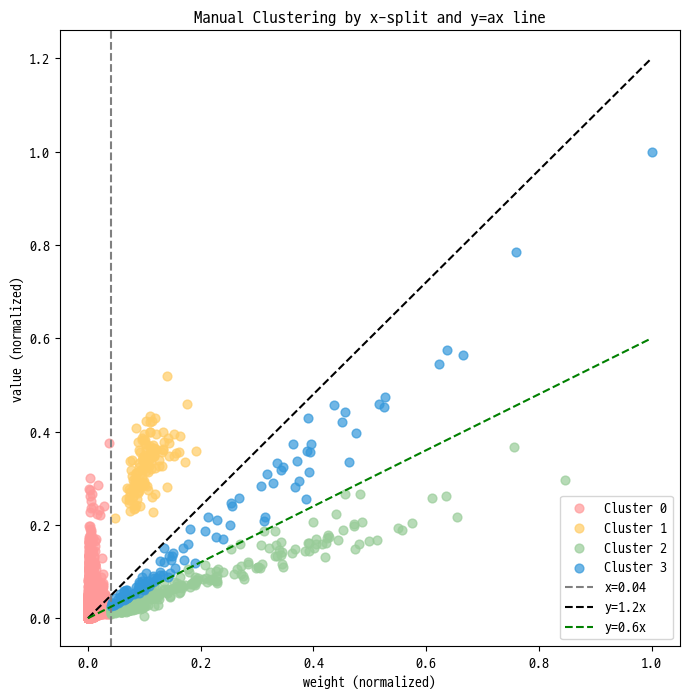

In [27]:
######
###### feature engineering 1:  weight-value categorizattion via manual clustering
######

# 최대 weight 값 기준 정규화 (0~1 범위로 맞추면 시각화 깔끔)
x = train['weight'] / train['weight'].max()
y = train['value'] / train['value'].max()

# 기준선 설정
x_split = 0.04     # x=0.3 경계선
a = 1.2            # y = a*x 기준선 (기울기)
b = 0.6            # y = b*x 기준선 (기울기)
train['cluster_manual'] = 0  # 기본값


#plt.imshow((x > x_split) & (y > a * x))



# 조건별 군집 분류
train.loc[(x <= x_split), 'cluster_manual'] = 0 # 분홍색 군집
train.loc[(x > x_split) & (y > a * x), 'cluster_manual'] = 1 # 노란색 군집
train.loc[(x > x_split) & (y <= a * x), 'cluster_manual'] = 2 # 초록색 군집
train.loc[(x > x_split) & (y <= a * x) & (y >= b * x), 'cluster_manual'] = 3 # 파란색 군집
############################################################################
# 시각화
plt.figure(figsize=(8,8))
colors = ['#FF9999','#FFCC66','#99CC99', '#3498db']
for i, color in enumerate(colors):
    plt.scatter(x[train['cluster_manual']==i],
                y[train['cluster_manual']==i],
                label=f'Cluster {i}', s=40, color=color, alpha=0.7)


# 기준선들 시각화
plt.axvline(x=x_split, color='gray', linestyle='--', label=f'x={x_split}')
plt.plot(np.linspace(0,1,100),
         a * np.linspace(0,1,100),
         color='black', linestyle='--', label=f'y={a}x')
plt.plot(np.linspace(0,1,100),
         b * np.linspace(0,1,100),
         color='green', linestyle='--', label=f'y={b}x')

plt.xlabel('weight (normalized)')
plt.ylabel('value (normalized)')
plt.title('Manual Clustering by x-split and y=ax line')
plt.legend()
plt.show()

In [28]:
train.head(3)

,item_id,year,month,seq,type,hs4,weight,quantity,value,cluster_manual
0,DEWLVASR,2022,1,1.0,1,3038,14858.0,0.0,32688.0,0
1,ELQGMQWE,2022,1,1.0,1,2002,62195.0,0.0,110617.0,0
2,AHMDUILJ,2022,1,1.0,1,2102,18426.0,0.0,72766.0,0


In [29]:
#train.groupby(['item_id' ,'cluster_manual'])['item_id'].size()
print(train.groupby('cluster_manual')['item_id'].apply(lambda x: len(np.unique(x))))
train.groupby('cluster_manual')['item_id'].apply(lambda x: np.unique(x))

cluster_manual
0    99
1     1
2     7
3     4
Name: item_id, dtype: int64


cluster_manual
0    [AANGBULD, AHMDUILJ, ANWUJOKX, APQGTRMF, ATLDM...
1                                           [FCYBOAXC]
2    [ATLDMDBO, BTMOEMEP, HXYSSRXE, LLHREMKS, LRVGF...
3             [ATLDMDBO, BTMOEMEP, LRVGFDFM, SDWAYPIK]
Name: item_id, dtype: object

In [30]:
tmp_df_seq = train.groupby(["cluster_manual"], as_index=False)["item_id"].apply(lambda x: np.unique(x))
tmp_df_seq['cluster_manual_len'] = train.groupby(["cluster_manual"])["item_id"].apply(lambda x: len(np.unique(x))).values#['item_id']#.sort_values(by='item_id', ascending=False, key = lambda x: len(x), axis=1)#.reset_index(drop=True)['item_id']
tmp_df_seq

dct_seq_cat = tmp_df_seq[['cluster_manual','item_id']].set_index('cluster_manual').to_dict()['item_id']
dct_seq_cat

{0: array(['AANGBULD', 'AHMDUILJ', 'ANWUJOKX', 'APQGTRMF', 'ATLDMDBO',
        'AXULOHBQ', 'BEZYMBBT', 'BJALXPFS', 'BLANHGYY', 'BSRMSVTC',
        'BTMOEMEP', 'BUZIIBYG', 'CCLHWFWF', 'DBWLZWNK', 'DDEXPPXU',
        'DEWLVASR', 'DJBLNPNC', 'DNMPSKTB', 'DUCMGGNW', 'ELQGMQWE',
        'EVBVXETX', 'FDXPMYGF', 'FITUEHWN', 'FQCLOEXA', 'FRHNWLNI',
        'FTSVTTSR', 'FWUCPMMW', 'GIKPEWTY', 'GKQIJYDH', 'GMBFCMIU',
        'GYHKIVQT', 'HCDTGMST', 'HXYSSRXE', 'IGDVVKUD', 'JBVHSUWY',
        'JERHKLYW', 'JPBRUTWP', 'JSLXRQOK', 'KAGJCHMR', 'KEUWZRKO',
        'KFQSHBNH', 'KJNSOAHR', 'LLHREMKS', 'LPHPPJUG', 'LRVGFDFM',
        'LSOIUSXD', 'LTOYKIML', 'LUENUFGA', 'MBSBZBXA', 'MIRCVAMV',
        'NAQIHUKZ', 'NZKBIBNU', 'OGAFEHLU', 'OJIFIHMZ', 'OKMBFVKS',
        'OXKURKXR', 'PLMZALFA', 'PYZMVUWD', 'QJQJSWFU', 'QKXNTIIB',
        'QRKRBYJL', 'QSDCUCLB', 'QVLMOEYE', 'RAWUKQMJ', 'RCBZUSIM',
        'RJCAXSGH', 'RJGPVEXX', 'ROACSLMG', 'RUVXNNVA', 'SAAYMURU',
        'SAHWCZNH', 'SDWAYPIK', 'SNHYOVBM', '

In [31]:
len(set(dct_seq_cat[0])), len(set(dct_seq_cat[1])), len(set(dct_seq_cat[2])), len(set(dct_seq_cat[3]))

(99, 1, 7, 4)

In [32]:
print(set(dct_seq_cat[0]).intersection(set(dct_seq_cat[1]))) # 중복 없음
print(sorted(set(dct_seq_cat[0]).intersection(set(dct_seq_cat[2])))) # ['ATLDMDBO', 'BTMOEMEP', 'HXYSSRXE', 'LLHREMKS', 'LRVGFDFM', 'SDWAYPIK', 'XMKRPGLB']
print(set(dct_seq_cat[1]).intersection(set(dct_seq_cat[2]))) # 중복 없음
print(sorted(set(dct_seq_cat[0]).intersection(set(dct_seq_cat[3])))) # ['ATLDMDBO', 'BTMOEMEP', 'LRVGFDFM', 'SDWAYPIK']
print(set(dct_seq_cat[1]).intersection(set(dct_seq_cat[3]))) # 중복 없음
print(sorted(set(dct_seq_cat[2]).intersection(set(dct_seq_cat[3])))) # ['ATLDMDBO', 'BTMOEMEP', 'LRVGFDFM', 'SDWAYPIK']

set()
['ATLDMDBO', 'BTMOEMEP', 'HXYSSRXE', 'LLHREMKS', 'LRVGFDFM', 'SDWAYPIK', 'XMKRPGLB']
set()
['ATLDMDBO', 'BTMOEMEP', 'LRVGFDFM', 'SDWAYPIK']
set()
['ATLDMDBO', 'BTMOEMEP', 'LRVGFDFM', 'SDWAYPIK']


In [33]:
dct_wv_cat_inv = {1:['FCYBOAXC'], 
              2:['ATLDMDBO', 'BTMOEMEP', 'LRVGFDFM', 'SDWAYPIK'], 
              3:['HXYSSRXE', 'LLHREMKS', 'XMKRPGLB'], 
              4:sorted(set(dct_seq_cat[0]).difference(set(dct_seq_cat[2]))) }
dct_wv_cat_inv[4][:10]

['AANGBULD',
 'AHMDUILJ',
 'ANWUJOKX',
 'APQGTRMF',
 'AXULOHBQ',
 'BEZYMBBT',
 'BJALXPFS',
 'BLANHGYY',
 'BSRMSVTC',
 'BUZIIBYG']

In [34]:
dct_wv_cat = {}
for k, v in dct_wv_cat_inv.items():
    for item in v:
        dct_wv_cat[item] = k
len(dct_wv_cat) # fe-weight-value cat. dictionary

100

In [35]:
######
###### feature engineering 2:  seq-item_id categorization
######

seq_pivot_df_cnt = pd.pivot_table(train, index='item_id', columns="month", values='seq',aggfunc='count', margins=True, margins_name="seq_total")

tmp_ser = seq_pivot_df_cnt['seq_total'].iloc[:-1]
dct_seq_total = pd.cut(tmp_ser, bins= [0, 40, 80, tmp_ser.max()], labels = ['seq_cnt_low',  'seq_cnt_mid',  'seq_cnt_high'] ).to_dict()
dct_seq_total

train['seq_cat'] = train["item_id"].map(dct_seq_total)
display(train.head(3))

tmp_df_seq = train.groupby(["seq_cat"], as_index=False)["item_id"].apply(lambda x: np.unique(x))
tmp_df_seq['seq_cat_len'] = train.groupby(["seq_cat"])["item_id"].apply(lambda x: len(np.unique(x))).values

dct_seq_cat_inv = tmp_df_seq[['seq_cat','item_id']].set_index('seq_cat').to_dict()['item_id']
dct_seq_cat_inv


,item_id,year,month,seq,type,hs4,weight,quantity,value,cluster_manual,seq_cat
0,DEWLVASR,2022,1,1.0,1,3038,14858.0,0.0,32688.0,0,seq_cnt_high
1,ELQGMQWE,2022,1,1.0,1,2002,62195.0,0.0,110617.0,0,seq_cnt_high
2,AHMDUILJ,2022,1,1.0,1,2102,18426.0,0.0,72766.0,0,seq_cnt_high


{'seq_cnt_high': array(['AHMDUILJ', 'APQGTRMF', 'ATLDMDBO', 'AXULOHBQ', 'BEZYMBBT',
        'BJALXPFS', 'BSRMSVTC', 'BTMOEMEP', 'BUZIIBYG', 'CCLHWFWF',
        'DBWLZWNK', 'DDEXPPXU', 'DEWLVASR', 'DNMPSKTB', 'DUCMGGNW',
        'ELQGMQWE', 'EVBVXETX', 'FCYBOAXC', 'FDXPMYGF', 'FITUEHWN',
        'FQCLOEXA', 'FRHNWLNI', 'FTSVTTSR', 'GKQIJYDH', 'GYHKIVQT',
        'HCDTGMST', 'HXYSSRXE', 'IGDVVKUD', 'JBVHSUWY', 'JERHKLYW',
        'JPBRUTWP', 'JSLXRQOK', 'KAGJCHMR', 'KEUWZRKO', 'KJNSOAHR',
        'LLHREMKS', 'LPHPPJUG', 'LRVGFDFM', 'LSOIUSXD', 'LTOYKIML',
        'LUENUFGA', 'MBSBZBXA', 'NZKBIBNU', 'OJIFIHMZ', 'OKMBFVKS',
        'OXKURKXR', 'QJQJSWFU', 'QKXNTIIB', 'QRKRBYJL', 'QVLMOEYE',
        'RAWUKQMJ', 'RCBZUSIM', 'RJGPVEXX', 'ROACSLMG', 'SAAYMURU',
        'SAHWCZNH', 'SDWAYPIK', 'SNHYOVBM', 'STZDBITS', 'SUOYXCHP',
        'UGEQLMXM', 'UIFPPCLR', 'UQYUIVVR', 'UXSPKBJR', 'VBYCLTYZ',
        'VMAQSTJE', 'VUAFAIYJ', 'VWMBASNE', 'WBLJNPZQ', 'WHPUAOID',
        'WPQXWHYO', 'WQMVCOEM', 

In [36]:
dct_seq_cat = {}
for k, v in dct_seq_cat_inv.items():
    for item in v:
        if k=="seq_cnt_low": dct_seq_cat[item] = 1
        elif k=="seq_cnt_mid": dct_seq_cat[item] = 2
        elif k=="seq_cnt_high": dct_seq_cat[item] = 3
len(dct_seq_cat) # fe-seq-item_id cat. dictionary

100

In [37]:
######
###### feature engineering 3:  seq-item_id categorization
######

tmp_df = train.groupby(["hs4"], as_index=False)["item_id"].apply(lambda x: np.unique(x))
tmp_df['item_id_len'] = train.groupby(["hs4"], as_index=False)["item_id"].apply(lambda x: len(np.unique(x)))['item_id']
hs4_tmp_df = tmp_df.sort_values(by='item_id_len', ascending=False).reset_index(drop=True)
display(hs4_tmp_df.head(20))
print(hs4_tmp_df['hs4'][:20].values) # [2805 3824 8501 2811 8102 8505 3815 2807 7207 2846 3102 2529 8714 1210 2002 2701 2612 2501 2102 2836]
print(hs4_tmp_df.shape) # (71, 3)
hs4_tmp_df['item_id_len'][:20].sum() # 49

,hs4,item_id,item_id_len
0,2805,"[BSRMSVTC, DJBLNPNC, RCBZUSIM, SUOYXCHP, WQMVC...",6
1,3824,"[FCYBOAXC, IGDVVKUD, LPHPPJUG, PYZMVUWD, SNHYO...",5
2,8501,"[GKQIJYDH, KFQSHBNH, QKXNTIIB, RJCAXSGH, UQYUI...",5
3,2811,"[DNMPSKTB, RJGPVEXX, VWMBASNE, WPQXWHYO]",4
4,8102,"[FQCLOEXA, KEUWZRKO, UIFPPCLR]",3
5,8505,"[GYHKIVQT, ROACSLMG, VBYCLTYZ]",3
6,3815,"[OJIFIHMZ, STZDBITS, XIIEJNEE]",3
7,2807,"[DDEXPPXU, LLHREMKS, YSYHGLQK]",3
8,7207,"[SDWAYPIK, TGOELCAG]",2
9,2846,"[FRHNWLNI, MBSBZBXA]",2


[2805 3824 8501 2811 8102 8505 3815 2807 7207 2846 3102 2529 8714 1210
 2002 2701 2612 2501 2102 2836]
(71, 3)


np.int64(49)

In [38]:
# for i, row in enumerate(hs4_tmp_df):
#     print(i, row)
#     #break

tmp_seq = [ x if x < 14 else 14 for x in range(1, len(hs4_tmp_df)+1) ]
hs4_tmp_df['hs4_cat'] = tmp_seq
pd.concat([hs4_tmp_df.head(15), hs4_tmp_df.tail(5)])


,hs4,item_id,item_id_len,hs4_cat
0,2805,"[BSRMSVTC, DJBLNPNC, RCBZUSIM, SUOYXCHP, WQMVC...",6,1
1,3824,"[FCYBOAXC, IGDVVKUD, LPHPPJUG, PYZMVUWD, SNHYO...",5,2
2,8501,"[GKQIJYDH, KFQSHBNH, QKXNTIIB, RJCAXSGH, UQYUI...",5,3
3,2811,"[DNMPSKTB, RJGPVEXX, VWMBASNE, WPQXWHYO]",4,4
4,8102,"[FQCLOEXA, KEUWZRKO, UIFPPCLR]",3,5
5,8505,"[GYHKIVQT, ROACSLMG, VBYCLTYZ]",3,6
6,3815,"[OJIFIHMZ, STZDBITS, XIIEJNEE]",3,7
7,2807,"[DDEXPPXU, LLHREMKS, YSYHGLQK]",3,8
8,7207,"[SDWAYPIK, TGOELCAG]",2,9
9,2846,"[FRHNWLNI, MBSBZBXA]",2,10


In [39]:
display(hs4_tmp_df[hs4_tmp_df['hs4']==4202]) # 42	4202	[QVLMOEYE]	1	14

display(hs4_tmp_df[hs4_tmp_df['hs4']==2833])

display(hs4_tmp_df[hs4_tmp_df['hs4']==4302])

,hs4,item_id,item_id_len,hs4_cat
42,4202,[QVLMOEYE],1,14


,hs4,item_id,item_id_len,hs4_cat
37,2833,[LUENUFGA],1,14


,hs4,item_id,item_id_len,hs4_cat
41,4302,[TANNMIMB],1,14


In [40]:
cp_hs4_tmp_df = hs4_tmp_df[['hs4_cat','item_id']].copy()
print(cp_hs4_tmp_df[hs4_tmp_df['hs4_cat']==14].shape)
lst_hs4_cat14 = []
for item in cp_hs4_tmp_df[hs4_tmp_df['hs4_cat']==14]['item_id']:
    lst_hs4_cat14.append(item.tolist()[0])
    
print(len(lst_hs4_cat14))
lst_hs4_cat14



(58, 2)
58


['JBVHSUWY',
 'ELQGMQWE',
 'FWUCPMMW',
 'RUVXNNVA',
 'XIPPENFQ',
 'AHMDUILJ',
 'HXYSSRXE',
 'QRKRBYJL',
 'BJALXPFS',
 'ATLDMDBO',
 'DEWLVASR',
 'PLMZALFA',
 'ZGJXVMNI',
 'UXSPKBJR',
 'QJQJSWFU',
 'EVBVXETX',
 'BEZYMBBT',
 'SAAYMURU',
 'NAQIHUKZ',
 'DUCMGGNW',
 'JPBRUTWP',
 'RAWUKQMJ',
 'GMBFCMIU',
 'SAHWCZNH',
 'LUENUFGA',
 'QSDCUCLB',
 'MIRCVAMV',
 'ANWUJOKX',
 'TANNMIMB',
 'QVLMOEYE',
 'LTOYKIML',
 'JERHKLYW',
 'AANGBULD',
 'ZXERAXWP',
 'WHPUAOID',
 'AXULOHBQ',
 'DBWLZWNK',
 'LSOIUSXD',
 'JSLXRQOK',
 'XUOIQPFL',
 'WBLJNPZQ',
 'OXKURKXR',
 'CCLHWFWF',
 'VUAFAIYJ',
 'HCDTGMST',
 'OKMBFVKS',
 'NZKBIBNU',
 'FDXPMYGF',
 'OGAFEHLU',
 'GIKPEWTY',
 'KAGJCHMR',
 'ZCELVYQU',
 'APQGTRMF',
 'KJNSOAHR',
 'VMAQSTJE',
 'XIFHSOWQ',
 'BLANHGYY',
 'BUZIIBYG']

In [41]:
dct_hs4_cat_inv = hs4_tmp_df[['hs4_cat','item_id']][:13].set_index('hs4_cat').to_dict()['item_id']
dct_hs4_cat_inv[14] = np.array(lst_hs4_cat14)
dct_hs4_cat_inv

{1: array(['BSRMSVTC', 'DJBLNPNC', 'RCBZUSIM', 'SUOYXCHP', 'WQMVCOEM',
        'ZKENOUDA'], dtype=object),
 2: array(['FCYBOAXC', 'IGDVVKUD', 'LPHPPJUG', 'PYZMVUWD', 'SNHYOVBM'],
       dtype=object),
 3: array(['GKQIJYDH', 'KFQSHBNH', 'QKXNTIIB', 'RJCAXSGH', 'UQYUIVVR'],
       dtype=object),
 4: array(['DNMPSKTB', 'RJGPVEXX', 'VWMBASNE', 'WPQXWHYO'], dtype=object),
 5: array(['FQCLOEXA', 'KEUWZRKO', 'UIFPPCLR'], dtype=object),
 6: array(['GYHKIVQT', 'ROACSLMG', 'VBYCLTYZ'], dtype=object),
 7: array(['OJIFIHMZ', 'STZDBITS', 'XIIEJNEE'], dtype=object),
 8: array(['DDEXPPXU', 'LLHREMKS', 'YSYHGLQK'], dtype=object),
 9: array(['SDWAYPIK', 'TGOELCAG'], dtype=object),
 10: array(['FRHNWLNI', 'MBSBZBXA'], dtype=object),
 11: array(['BTMOEMEP', 'LRVGFDFM'], dtype=object),
 12: array(['FTSVTTSR', 'XMKRPGLB'], dtype=object),
 13: array(['FITUEHWN', 'UGEQLMXM'], dtype=object),
 14: array(['JBVHSUWY', 'ELQGMQWE', 'FWUCPMMW', 'RUVXNNVA', 'XIPPENFQ',
        'AHMDUILJ', 'HXYSSRXE', 'QRKRBYJL', 'BJ

In [42]:
dct_hs4_cat = {}
for k, v in dct_hs4_cat_inv.items():
    for item in v:
        dct_hs4_cat[item] = k
print(len(dct_hs4_cat)) # fe-hs4-item_id cat. dictionary
#dct_hs4_cat

100


### monthly data


In [43]:
# year, month, item_id 기준으로 value 합산 (seq만 다르다면 value 합산)
monthly = (
    train
    .groupby(["item_id", "year", "month"], as_index=False)["value"]
    .sum()
)

# year, month를 하나의 키(ym)로 묶기
monthly["ym"] = pd.to_datetime(
    monthly["year"].astype(str) + "-" + monthly["month"].astype(str).str.zfill(2)
)

monthly.head()

,item_id,year,month,value,ym
0,AANGBULD,2022,1,14276.0,2022-01-01
1,AANGBULD,2022,2,52347.0,2022-02-01
2,AANGBULD,2022,3,53549.0,2022-03-01
3,AANGBULD,2022,5,26997.0,2022-05-01
4,AANGBULD,2022,6,84489.0,2022-06-01


### pivot

In [44]:
# item_id × ym 피벗 (월별 총 무역량 매트릭스 생성)
pivot_org = (
    monthly
    .pivot(index="item_id", columns="ym", values="value")
    .fillna(0.0)
)

print("pivot_org.shape: ", pivot_org.shape)
pivot_org.head()

pivot_org.shape:  (100, 43)


ym,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,...,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,14276.0,52347.0,53549.0,0.0,26997.0,84489.0,0.0,0.0,0.0,0.0,...,428725.0,144248.0,26507.0,25691.0,25805.0,0.0,38441.0,0.0,441275.0,533478.0
AHMDUILJ,242705.0,120847.0,197317.0,126142.0,71730.0,149138.0,186617.0,169995.0,140547.0,89292.0,...,123085.0,143451.0,78649.0,125098.0,80404.0,157401.0,115509.0,127473.0,89479.0,101317.0
ANWUJOKX,0.0,0.0,0.0,63580.0,81670.0,26424.0,8470.0,0.0,0.0,80475.0,...,0.0,0.0,0.0,27980.0,0.0,0.0,0.0,0.0,0.0,0.0
APQGTRMF,383999.0,512813.0,217064.0,470398.0,539873.0,582317.0,759980.0,216019.0,537693.0,205326.0,...,683581.0,2147.0,0.0,25013.0,77.0,20741.0,2403.0,3543.0,32430.0,40608.0
ATLDMDBO,143097177.0,103568323.0,118403737.0,121873741.0,115024617.0,65716075.0,146216818.0,97552978.0,72341427.0,87454167.0,...,60276050.0,30160198.0,42613728.0,64451013.0,38667429.0,29354408.0,42450439.0,37136720.0,32181798.0,57090235.0


In [45]:
##### 로컬 테스팅을 위해, pivot.iloc[:, :-1]과 pivot.iloc[:, [-1]]로  split
target_pivot = pivot_org.iloc[:, [-1]].copy()
pivot = pivot_org.iloc[:, :-1].copy()

print("pivot.shape: ", pivot.shape)
pivot.head(3)

pivot.shape:  (100, 42)


ym,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,...,2024-09-01,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,14276.0,52347.0,53549.0,0.0,26997.0,84489.0,0.0,0.0,0.0,0.0,...,313076.0,428725.0,144248.0,26507.0,25691.0,25805.0,0.0,38441.0,0.0,441275.0
AHMDUILJ,242705.0,120847.0,197317.0,126142.0,71730.0,149138.0,186617.0,169995.0,140547.0,89292.0,...,184920.0,123085.0,143451.0,78649.0,125098.0,80404.0,157401.0,115509.0,127473.0,89479.0
ANWUJOKX,0.0,0.0,0.0,63580.0,81670.0,26424.0,8470.0,0.0,0.0,80475.0,...,0.0,0.0,0.0,0.0,27980.0,0.0,0.0,0.0,0.0,0.0


In [46]:
# dictionary of "item_id": y_true value:
target_pivot.head()
target_pivot.to_dict().keys()#['2025-07-01 00:00:00']
dct_y_true = target_pivot.to_dict()[pd.to_datetime('2025-07-01')]

for k,v in dct_y_true.items():
    if v==0: print(k, v)

ANWUJOKX 0.0
GIKPEWTY 0.0
GMBFCMIU 0.0
HCDTGMST 0.0
NAQIHUKZ 0.0
OGAFEHLU 0.0
PLMZALFA 0.0
QSDCUCLB 0.0
RUVXNNVA 0.0
TANNMIMB 0.0


## 2. 공행성쌍 탐색

In [47]:
#pairs = find_comovement_pairs(pivot_org, max_lag, min_nonzero, corr_threshold) # pivot_org로 한것은 default pairs를 유지하기위함
pairs = find_comovement_pairs_diff(pivot_org, max_lag, min_nonzero, corr_threshold) # pivot_org로 한것은 default pairs를 유지하기위함
print("탐색된 공행성쌍 수:", len(pairs)) # 탐색된 공행성쌍 수: 1425

EXP_LOG["탐색된 공행성쌍 pairs.shape"] = pairs.shape
pairs.head()

100it [00:07, 12.76it/s]

탐색된 공행성쌍 수: 1562


,leading_item_id,following_item_id,best_lag,max_corr
0,AANGBULD,APQGTRMF,6,0.417464
1,AANGBULD,BJALXPFS,6,0.524327
2,AANGBULD,DEWLVASR,6,0.483517
3,AANGBULD,FTSVTTSR,6,-0.491995
4,AANGBULD,GKQIJYDH,6,0.541411


In [48]:
pairs['max_corr_abs'] = pairs['max_corr'].apply(np.abs)
pairs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1562 entries, 0 to 1561
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   leading_item_id    1562 non-null   object 
 1   following_item_id  1562 non-null   object 
 2   best_lag           1562 non-null   int64  
 3   max_corr           1562 non-null   float64
 4   max_corr_abs       1562 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 61.1+ KB


In [49]:
df_pairs = pairs.groupby('leading_item_id')['following_item_id'] \
    .aggregate(["size"]).sort_values(by='size', ascending=False) # or 'count'
df_pairs    

###
### ==> 따라서 100개 아이템중 9개는 공행성쌍이 탐지 되지않았다. ==> 공행성쌍이 탐지 vs. 공행성쌍이 탐지 실패 아이템으로 cat. 가능 => 쓸모는 없다. 공행성쌍에 포함되지않으면 어차피 학습데이터로 들어가지않는다.
###

dct_pair_detection = {'comv_yes':df_pairs.index.to_list() , 
                      'comv_no': set(train['item_id']).difference(set(df_pairs.index.to_list()))}
print("공행성이 탐지되지 않은 상품수: ", len(dct_pair_detection['comv_no']))
print("공행성이 탐지되지 않은 상품id: ", sorted(dct_pair_detection['comv_no']))

print("공행성 탐지된 상품수: ", len(dct_pair_detection['comv_yes']))
print("공행성이 탐지된 상품id: ", sorted(dct_pair_detection['comv_yes'])) 
### logging
EXP_LOG["공행성이 탐지되지 않은 상품수"] = len(dct_pair_detection['comv_no'])
EXP_LOG["공행성이 탐지되지 않은 상품id:"] = sorted(dct_pair_detection['comv_no'])
EXP_LOG["공행성이 탐지된 상품수"] = len(dct_pair_detection['comv_yes'])

공행성이 탐지되지 않은 상품수:  9
공행성이 탐지되지 않은 상품id:  ['ANWUJOKX', 'GIKPEWTY', 'GMBFCMIU', 'KFQSHBNH', 'PLMZALFA', 'QSDCUCLB', 'RJCAXSGH', 'RUVXNNVA', 'TANNMIMB']
공행성 탐지된 상품수:  91
공행성이 탐지된 상품id:  ['AANGBULD', 'AHMDUILJ', 'APQGTRMF', 'ATLDMDBO', 'AXULOHBQ', 'BEZYMBBT', 'BJALXPFS', 'BLANHGYY', 'BSRMSVTC', 'BTMOEMEP', 'BUZIIBYG', 'CCLHWFWF', 'DBWLZWNK', 'DDEXPPXU', 'DEWLVASR', 'DJBLNPNC', 'DNMPSKTB', 'DUCMGGNW', 'ELQGMQWE', 'EVBVXETX', 'FCYBOAXC', 'FDXPMYGF', 'FITUEHWN', 'FQCLOEXA', 'FRHNWLNI', 'FTSVTTSR', 'FWUCPMMW', 'GKQIJYDH', 'GYHKIVQT', 'HCDTGMST', 'HXYSSRXE', 'IGDVVKUD', 'JBVHSUWY', 'JERHKLYW', 'JPBRUTWP', 'JSLXRQOK', 'KAGJCHMR', 'KEUWZRKO', 'KJNSOAHR', 'LLHREMKS', 'LPHPPJUG', 'LRVGFDFM', 'LSOIUSXD', 'LTOYKIML', 'LUENUFGA', 'MBSBZBXA', 'MIRCVAMV', 'NAQIHUKZ', 'NZKBIBNU', 'OGAFEHLU', 'OJIFIHMZ', 'OKMBFVKS', 'OXKURKXR', 'PYZMVUWD', 'QJQJSWFU', 'QKXNTIIB', 'QRKRBYJL', 'QVLMOEYE', 'RAWUKQMJ', 'RCBZUSIM', 'RJGPVEXX', 'ROACSLMG', 'SAAYMURU', 'SAHWCZNH', 'SDWAYPIK', 'SNHYOVBM', 'STZDBITS', 'SUOYXCHP', 

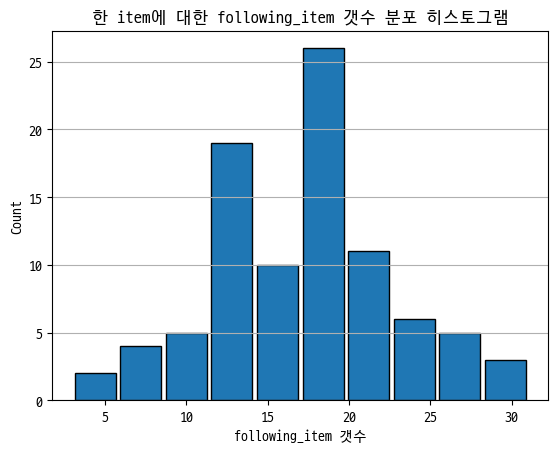

In [50]:
plot_histogram(input_var_col = df_pairs['size'] , num_bin = 10,
                title_str = "한 item에 대한 following_item 갯수 분포 히스토그램",
                xlbl_str = 'following_item 갯수',
                verbose = False)

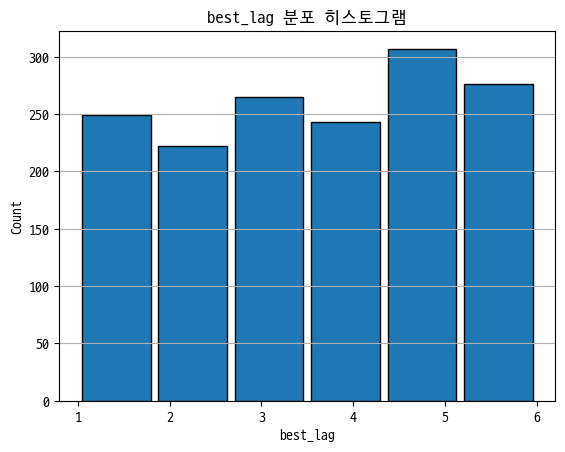

In [51]:
plot_histogram(input_var_col = pairs['best_lag'] , num_bin = 6,
                title_str = "best_lag 분포 히스토그램",
                xlbl_str = 'best_lag',
                verbose = False)

In [52]:
##### answer_df 생성
display(pairs.head(3))
answer_df = pairs[['leading_item_id', 'following_item_id']].copy()

display(answer_df)
answer_df['value'] = answer_df['following_item_id'].apply(lambda x: dct_y_true[x])
answer_df.head()

,leading_item_id,following_item_id,best_lag,max_corr,max_corr_abs
0,AANGBULD,APQGTRMF,6,0.417464,0.417464
1,AANGBULD,BJALXPFS,6,0.524327,0.524327
2,AANGBULD,DEWLVASR,6,0.483517,0.483517


,leading_item_id,following_item_id
0,AANGBULD,APQGTRMF
1,AANGBULD,BJALXPFS
2,AANGBULD,DEWLVASR
3,AANGBULD,FTSVTTSR
4,AANGBULD,GKQIJYDH
...,...,...
1557,ZXERAXWP,SUOYXCHP
1558,ZXERAXWP,UIFPPCLR
1559,ZXERAXWP,UXSPKBJR
1560,ZXERAXWP,WHPUAOID


,leading_item_id,following_item_id,value
0,AANGBULD,APQGTRMF,40608.0
1,AANGBULD,BJALXPFS,174914.0
2,AANGBULD,DEWLVASR,482787.0
3,AANGBULD,FTSVTTSR,246916.0
4,AANGBULD,GKQIJYDH,11621444.0


In [53]:
for gn, gdf in answer_df.groupby('following_item_id'):
    print("group name: ", gn)
    print("group dataframe: \n", gdf)
    break

group name:  AANGBULD
group dataframe: 
      leading_item_id following_item_id     value
94          BEZYMBBT          AANGBULD  533478.0
309         ELQGMQWE          AANGBULD  533478.0
644         KAGJCHMR          AANGBULD  533478.0
680         LLHREMKS          AANGBULD  533478.0
697         LPHPPJUG          AANGBULD  533478.0
789         MIRCVAMV          AANGBULD  533478.0
826         NZKBIBNU          AANGBULD  533478.0
950         QJQJSWFU          AANGBULD  533478.0
1160        STZDBITS          AANGBULD  533478.0
1326        VUAFAIYJ          AANGBULD  533478.0
1373        WPQXWHYO          AANGBULD  533478.0
1450        XMKRPGLB          AANGBULD  533478.0


In [54]:
pairs.head()

,leading_item_id,following_item_id,best_lag,max_corr,max_corr_abs
0,AANGBULD,APQGTRMF,6,0.417464,0.417464
1,AANGBULD,BJALXPFS,6,0.524327,0.524327
2,AANGBULD,DEWLVASR,6,0.483517,0.483517
3,AANGBULD,FTSVTTSR,6,-0.491995,0.491995
4,AANGBULD,GKQIJYDH,6,0.541411,0.541411


In [55]:
#####
##### Feature Engineering 변수 추가
#####

# Engineered Feature 를 pairs에 추가:  위에서 feat. eng. 한 범주화 변수 추가 ()
pairs['wv_cat'] = pairs['following_item_id'].map(dct_wv_cat) # following_item_id 에 대한 추론을 할 것이므로
pairs.head(3)

,leading_item_id,following_item_id,best_lag,max_corr,max_corr_abs,wv_cat
0,AANGBULD,APQGTRMF,6,0.417464,0.417464,4
1,AANGBULD,BJALXPFS,6,0.524327,0.524327,4
2,AANGBULD,DEWLVASR,6,0.483517,0.483517,4


In [56]:
# Engineered Feature 를 pairs에 추가:  위에서 feat. eng. 한 범주화 변수 추가 ()
pairs['seq_cat'] = pairs['following_item_id'].map(dct_seq_cat) # following_item_id 에 대한 추론을 할 것이므로
pairs.head(3)

,leading_item_id,following_item_id,best_lag,max_corr,max_corr_abs,wv_cat,seq_cat
0,AANGBULD,APQGTRMF,6,0.417464,0.417464,4,3
1,AANGBULD,BJALXPFS,6,0.524327,0.524327,4,3
2,AANGBULD,DEWLVASR,6,0.483517,0.483517,4,3


In [57]:
# Engineered Feature 를 pairs에 추가:  위에서 feat. eng. 한 범주화 변수 추가 ()
pairs['hs4_cat'] = pairs['following_item_id'].map(dct_hs4_cat) # following_item_id 에 대한 추론을 할 것이므로
pairs.head(3)

,leading_item_id,following_item_id,best_lag,max_corr,max_corr_abs,wv_cat,seq_cat,hs4_cat
0,AANGBULD,APQGTRMF,6,0.417464,0.417464,4,3,14
1,AANGBULD,BJALXPFS,6,0.524327,0.524327,4,3,14
2,AANGBULD,DEWLVASR,6,0.483517,0.483517,4,3,14


## 4. ML 모델 학습 + 5. 회귀 모델 추론
- 시계열 데이터 안에서 '한 달 뒤 총 무역량(value)을 맞추는 문제'로 self-supervised 학습
- 탐색된 모든 공행성쌍 (A,B)에 대해 월 t마다 학습 샘플 생성
- input X:
1) B_t (현재 총 무역량(value))
2) B_{t-1} (직전 달 총 무역량(value))
3) A_{t-lag} (lag 반영된 총 무역량(value))
4) max_corr, best_lag (관계 특성)

+ engineered features:
5) weight-value cat.

- target y:
1) B_{t+1} (다음 달 총 무역량(value))
- 이러한 모든 샘플을 합쳐 LinearRegression 회귀 모델을 학습

In [58]:
##########
########## 모델 학습 Step1: 일단 정해진 기본값 파라미터에서 성능을 확인 
##########

### sklearn GBT
from sklearn import datasets, ensemble

### 1) 학습 데이터 생성
#df_train_model = build_training_data(pivot_org, pairs) # 생성된 학습 데이터의 shape : (54743, 6)
#df_train_model = build_training_data(pivot, pairs) # 생성된 학습 데이터의 shape : (53318, 6)
#df_train_model = build_training_data_fe(pivot, pairs, add_fe=['wv_cat']) # 생성된 학습 데이터의 shape : (53318, 7)
#df_train_model = build_training_data_fe(pivot, pairs, add_fe=['wv_cat', 'seq_cat']) # 생성된 학습 데이터의 shape : (53318, 8)
df_train_model = build_training_data_fe(pivot, pairs, add_fe=['wv_cat', 'seq_cat', 'hs4_cat']) # 생성된 학습 데이터의 shape : (53318, 9)

print('생성된 학습 데이터의 shape :', df_train_model.shape)
display(df_train_model.head())
EXP_LOG['생성된 학습 데이터의 shape'] = df_train_model.shape

### 2) X, y 준비
#feature_cols = ['b_t', 'b_t_1', 'a_t_lag', 'max_corr', 'best_lag']
#feature_cols = ['b_t', 'b_t_1', 'a_t_lag', 'max_corr', 'best_lag', 'wv_cat']
#feature_cols = ['b_t', 'b_t_1', 'a_t_lag', 'max_corr', 'best_lag', 'wv_cat', 'seq_cat']
feature_cols = ['b_t', 'b_t_1', 'a_t_lag', 'max_corr', 'best_lag', 'wv_cat', 'seq_cat', 'hs4_cat']

train_X = df_train_model[feature_cols].values
train_y = df_train_model["target"].values


### 3) 모델 준비 및 학습
# params = {
#     "n_estimators": 500,
#     "max_depth": 4,
#     "min_samples_split": 5,
#     "learning_rate": 0.01,
#     "loss": "squared_error",
# }

#mdl = ensemble.GradientBoostingRegressor(**params)
mdl = ensemble.GradientBoostingRegressor(random_state=42)
mdl.fit(train_X, train_y)

print(mdl.get_params())


### 4) 추론
#y_pred = predict(pivot, pairs, mdl)
#y_pred = predict_fe(pivot, pairs, mdl, add_fe=['wv_cat'])
#y_pred = predict_fe(pivot, pairs, mdl, add_fe=['wv_cat', 'seq_cat'])
y_pred = predict_fe(pivot, pairs, mdl, add_fe=['wv_cat', 'seq_cat','hs4_cat'])


### 5) Local test score
#comovement_score(answer_df, submission_df)
#y_true = target_pivot.copy() #  target_pivot.shape = (100, 1)
y_true = answer_df

local_exp_score = comovement_score(y_true , y_pred) #  y_pred.shape = (1425, 3)
print(float(local_exp_score)) # 0.7670925863654553 (baseline) -> 0.7750724995354716 (wv_cat) 
                            # -> 0.7804210526638351 (seq_cat) -> 0.7833437474190103 (hs4_cat)
EXP_LOG['local_exp_score'] = float(local_exp_score)


생성된 학습 데이터의 shape : (58391, 9)


,b_t,b_t_1,a_t_lag,max_corr,best_lag,wv_cat,seq_cat,hs4_cat,target
0,759980.0,582317.0,14276.0,0.417464,6.0,4.0,3.0,14.0,216019.0
1,216019.0,759980.0,52347.0,0.417464,6.0,4.0,3.0,14.0,537693.0
2,537693.0,216019.0,53549.0,0.417464,6.0,4.0,3.0,14.0,205326.0
3,205326.0,537693.0,0.0,0.417464,6.0,4.0,3.0,14.0,169440.0
4,169440.0,205326.0,26997.0,0.417464,6.0,4.0,3.0,14.0,698033.0


{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


1562it [00:00, 2227.65it/s]

########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4205124641910366
score(=0.6*S1 + 0.4*S2): 0.7682049856764146
0.7682049856764146


### Hyperparameter optimization: optuna
- https://optuna.org/#code_examples
- https://github.com/optuna/optuna-examples/tree/main
- https://optuna.readthedocs.io/en/stable/faq.html
- https://velog.io/@newnew_daddy/data02


In [63]:
# import optuna

# import sklearn.datasets
# import sklearn.ensemble
# import sklearn.svm


# y_true = answer_df
# X, y = train_X.copy(), train_y.copy()
# n_features = len(feature_cols)
# n_features_sqrt = int(np.sqrt(n_features))

# # FYI: Objective functions can take additional arguments
# # (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
# def objective(trial):
#     # iris = sklearn.datasets.load_iris()
#     # x, y = iris.data, iris.target


#     classifier_name = trial.suggest_categorical("regressor", ["SVR", "GradientBoosting"])
#     if classifier_name == "SVR":
#         svr_c = trial.suggest_float("svr_c", 1e-10, 1e10, log=True)
#         classifier_obj = sklearn.svm.SVR(C=svr_c, gamma="auto")
#     else:
#         gbt_max_depth = trial.suggest_int("gbt_max_depth", 2, 32, log=True)
#         gbt_learning_rate = trial.suggest_float("gbt_learning_rate", 10**-3, 10**0, log=True)
#         gbt_max_features = trial.suggest_int("gbt_max_features", n_features_sqrt, n_features, log=False)
#         gbt_min_samples_split = trial.suggest_int("gbt_min_samples_split", 2, 10, log=False)
#         gbt_min_samples_leaf = trial.suggest_int("gbt_min_samples_leaf", 1, 10, log=False)
#         gbt_n_estimators = trial.suggest_int("gbt_n_estimators", 10, 2000, log=True)

#         classifier_obj = sklearn.ensemble.GradientBoostingRegressor(
#             max_depth=gbt_max_depth, 
#             learning_rate = gbt_learning_rate,
#             max_features = gbt_max_features,
#             min_samples_split = gbt_min_samples_split,
#             min_samples_leaf = gbt_min_samples_leaf,
#             n_estimators=gbt_n_estimators
#         )

#     classifier_obj.fit(X, y)
#     y_pred = predict_fe(pivot, pairs, classifier_obj, add_fe=['wv_cat', 'seq_cat','hs4_cat'])
#     score = float(comovement_score(y_true , y_pred))  # 1- score: for score maximization
#     return score



# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100)
# print(study.best_trial)
# EXP_LOG['optuna Best Study'] = study.best_trial

In [59]:
# from optuna.visualization import plot_intermediate_values

# plot_intermediate_values(study)

In [60]:
import optuna

import sklearn.datasets
import sklearn.ensemble
import sklearn.svm


y_true = answer_df
X, y = train_X.copy(), train_y.copy()
n_features = len(feature_cols)
n_features_sqrt = int(np.sqrt(n_features))

# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):

    gbt_max_depth = trial.suggest_int("gbt_max_depth", 2, 32, log=True)
    gbt_learning_rate = trial.suggest_float("gbt_learning_rate", 10**-3, 10**0, log=True)
    gbt_max_features = trial.suggest_int("gbt_max_features", n_features_sqrt, n_features, log=False)
    gbt_min_samples_split = trial.suggest_int("gbt_min_samples_split", 2, 10, log=False)
    gbt_min_samples_leaf = trial.suggest_int("gbt_min_samples_leaf", 1, 10, log=False)
    gbt_n_estimators = trial.suggest_int("gbt_n_estimators", 10, 2000, log=True)

    classifier_obj = sklearn.ensemble.GradientBoostingRegressor(
        max_depth=gbt_max_depth, 
        learning_rate = gbt_learning_rate,
        max_features = gbt_max_features,
        min_samples_split = gbt_min_samples_split,
        min_samples_leaf = gbt_min_samples_leaf,
        n_estimators=gbt_n_estimators,
        random_state = 42
    )

    classifier_obj.fit(X, y)
    y_pred = predict_fe(pivot, pairs, classifier_obj, add_fe=['wv_cat', 'seq_cat','hs4_cat'])
    score = float(comovement_score(y_true , y_pred))  # 1- score: for score maximization
    return score


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_trial)
EXP_LOG['optuna Best Study'] = study.best_trial

/home/yypark/miniconda3/envs/ai_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-11-22 19:11:50,727] A new study created in memory with name: no-name-a4bc79d7-30b4-4e0b-9709-8dbd1c735055
1562it [00:01, 1209.36it/s]
[I 2025-11-22 19:12:34,015] Trial 0 finished with value: 0.777849847293582 and parameters: {'gbt_max_depth': 16, 'gbt_learning_rate': 0.6083796256083684, 'gbt_max_features': 2, 'gbt_min_samples_split': 5, 'gbt_min_samples_leaf': 10, 'gbt_n_estimators': 383}. Best is trial 0 with value: 0.777849847293582.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.44462461823395494
score(=0.6*S1 + 0.4*S2): 0.777849847293582


1562it [00:04, 354.31it/s]
[I 2025-11-22 19:15:49,737] Trial 1 finished with value: 0.8073699832877662 and parameters: {'gbt_max_depth': 19, 'gbt_learning_rate': 0.004759433844819988, 'gbt_max_features': 2, 'gbt_min_samples_split': 4, 'gbt_min_samples_leaf': 2, 'gbt_n_estimators': 1444}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.5184249582194155
score(=0.6*S1 + 0.4*S2): 0.8073699832877662


1562it [00:00, 1795.37it/s]
[I 2025-11-22 19:16:17,740] Trial 2 finished with value: 0.6899625124424232 and parameters: {'gbt_max_depth': 31, 'gbt_learning_rate': 0.014210026470283141, 'gbt_max_features': 4, 'gbt_min_samples_split': 5, 'gbt_min_samples_leaf': 2, 'gbt_n_estimators': 92}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.22490628110605815
score(=0.6*S1 + 0.4*S2): 0.6899625124424232


1562it [00:00, 2661.21it/s]
[I 2025-11-22 19:16:20,433] Trial 3 finished with value: 0.6498525955861286 and parameters: {'gbt_max_depth': 14, 'gbt_learning_rate': 0.0064791810371101315, 'gbt_max_features': 5, 'gbt_min_samples_split': 4, 'gbt_min_samples_leaf': 5, 'gbt_n_estimators': 10}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.12463148896532161
score(=0.6*S1 + 0.4*S2): 0.6498525955861286


1562it [00:00, 2124.68it/s]
[I 2025-11-22 19:16:42,578] Trial 4 finished with value: 0.7342942928483372 and parameters: {'gbt_max_depth': 8, 'gbt_learning_rate': 0.019557714108074883, 'gbt_max_features': 7, 'gbt_min_samples_split': 2, 'gbt_min_samples_leaf': 7, 'gbt_n_estimators': 128}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.33573573212084307
score(=0.6*S1 + 0.4*S2): 0.7342942928483372


1562it [00:00, 2655.92it/s]
[I 2025-11-22 19:16:44,074] Trial 5 finished with value: 0.7708373783456574 and parameters: {'gbt_max_depth': 5, 'gbt_learning_rate': 0.3824662956847524, 'gbt_max_features': 5, 'gbt_min_samples_split': 2, 'gbt_min_samples_leaf': 6, 'gbt_n_estimators': 12}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.42709344586414344
score(=0.6*S1 + 0.4*S2): 0.7708373783456574


1562it [00:02, 697.36it/s]
[I 2025-11-22 19:21:25,253] Trial 6 finished with value: 0.7751063943380363 and parameters: {'gbt_max_depth': 12, 'gbt_learning_rate': 0.2789712478014552, 'gbt_max_features': 6, 'gbt_min_samples_split': 4, 'gbt_min_samples_leaf': 6, 'gbt_n_estimators': 1264}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.43776598584509063
score(=0.6*S1 + 0.4*S2): 0.7751063943380363


1562it [00:00, 1927.32it/s]
[I 2025-11-22 19:22:03,308] Trial 7 finished with value: 0.789919299207503 and parameters: {'gbt_max_depth': 12, 'gbt_learning_rate': 0.14819294368247102, 'gbt_max_features': 7, 'gbt_min_samples_split': 8, 'gbt_min_samples_leaf': 4, 'gbt_n_estimators': 150}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4747982480187577
score(=0.6*S1 + 0.4*S2): 0.789919299207503


1562it [00:03, 487.58it/s]
[I 2025-11-22 19:24:37,251] Trial 8 finished with value: 0.7935980493097311 and parameters: {'gbt_max_depth': 26, 'gbt_learning_rate': 0.22592983199532427, 'gbt_max_features': 2, 'gbt_min_samples_split': 10, 'gbt_min_samples_leaf': 1, 'gbt_n_estimators': 1005}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4839951232743278
score(=0.6*S1 + 0.4*S2): 0.7935980493097311


1562it [00:00, 1592.03it/s]
[I 2025-11-22 19:24:51,347] Trial 9 finished with value: 0.7784035062510369 and parameters: {'gbt_max_depth': 3, 'gbt_learning_rate': 0.1073164604122678, 'gbt_max_features': 3, 'gbt_min_samples_split': 7, 'gbt_min_samples_leaf': 8, 'gbt_n_estimators': 455}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4460087656275923
score(=0.6*S1 + 0.4*S2): 0.7784035062510369


1562it [00:02, 771.79it/s]
[I 2025-11-22 19:26:27,661] Trial 10 finished with value: 0.7320283606298894 and parameters: {'gbt_max_depth': 2, 'gbt_learning_rate': 0.0015098296207044304, 'gbt_max_features': 8, 'gbt_min_samples_split': 9, 'gbt_min_samples_leaf': 3, 'gbt_n_estimators': 1938}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.33007090157472363
score(=0.6*S1 + 0.4*S2): 0.7320283606298894


1562it [00:02, 562.73it/s]
[I 2025-11-22 19:28:30,498] Trial 11 finished with value: 0.7236197365934333 and parameters: {'gbt_max_depth': 32, 'gbt_learning_rate': 0.002973300449051466, 'gbt_max_features': 2, 'gbt_min_samples_split': 10, 'gbt_min_samples_leaf': 1, 'gbt_n_estimators': 712}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.3090493414835832
score(=0.6*S1 + 0.4*S2): 0.7236197365934333


1562it [00:02, 548.38it/s]
[I 2025-11-22 19:31:48,519] Trial 12 finished with value: 0.7933900234492108 and parameters: {'gbt_max_depth': 22, 'gbt_learning_rate': 0.05689931027597682, 'gbt_max_features': 3, 'gbt_min_samples_split': 7, 'gbt_min_samples_leaf': 1, 'gbt_n_estimators': 918}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4834750586230271
score(=0.6*S1 + 0.4*S2): 0.7933900234492108


1562it [00:00, 1642.14it/s]
[I 2025-11-22 19:32:09,801] Trial 13 finished with value: 0.7296260193748887 and parameters: {'gbt_max_depth': 7, 'gbt_learning_rate': 0.007259151997338485, 'gbt_max_features': 3, 'gbt_min_samples_split': 10, 'gbt_min_samples_leaf': 3, 'gbt_n_estimators': 311}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.3240650484372216
score(=0.6*S1 + 0.4*S2): 0.7296260193748887


1562it [00:07, 212.68it/s]
[I 2025-11-22 19:37:31,189] Trial 14 finished with value: 0.7239149966327396 and parameters: {'gbt_max_depth': 23, 'gbt_learning_rate': 0.0011416227984456006, 'gbt_max_features': 2, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 1, 'gbt_n_estimators': 1865}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.30978749158184915
score(=0.6*S1 + 0.4*S2): 0.7239149966327396


1562it [00:00, 1992.78it/s]
[I 2025-11-22 19:37:47,420] Trial 15 finished with value: 0.7448261262549789 and parameters: {'gbt_max_depth': 20, 'gbt_learning_rate': 0.044818357633930286, 'gbt_max_features': 4, 'gbt_min_samples_split': 6, 'gbt_min_samples_leaf': 3, 'gbt_n_estimators': 66}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.36206531563744715
score(=0.6*S1 + 0.4*S2): 0.7448261262549789


1562it [00:00, 2324.43it/s]
[I 2025-11-22 19:37:52,104] Trial 16 finished with value: 0.6522824352836779 and parameters: {'gbt_max_depth': 10, 'gbt_learning_rate': 0.003980629476299916, 'gbt_max_features': 4, 'gbt_min_samples_split': 8, 'gbt_min_samples_leaf': 2, 'gbt_n_estimators': 32}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.13070608820919472
score(=0.6*S1 + 0.4*S2): 0.6522824352836779


1562it [00:01, 1370.69it/s]
[I 2025-11-22 19:38:23,697] Trial 17 finished with value: 0.763798274668316 and parameters: {'gbt_max_depth': 18, 'gbt_learning_rate': 0.9287258200311357, 'gbt_max_features': 2, 'gbt_min_samples_split': 6, 'gbt_min_samples_leaf': 4, 'gbt_n_estimators': 240}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.40949568667078984
score(=0.6*S1 + 0.4*S2): 0.763798274668316


1562it [00:01, 1277.90it/s]
[I 2025-11-22 19:38:56,270] Trial 18 finished with value: 0.7835331769104319 and parameters: {'gbt_max_depth': 5, 'gbt_learning_rate': 0.09277673279443728, 'gbt_max_features': 3, 'gbt_min_samples_split': 4, 'gbt_min_samples_leaf': 2, 'gbt_n_estimators': 657}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.45883294227607974
score(=0.6*S1 + 0.4*S2): 0.7835331769104319


1562it [00:02, 523.37it/s]
[I 2025-11-22 19:46:04,333] Trial 19 finished with value: 0.7873233641520393 and parameters: {'gbt_max_depth': 26, 'gbt_learning_rate': 0.025786255194798977, 'gbt_max_features': 5, 'gbt_min_samples_split': 9, 'gbt_min_samples_leaf': 4, 'gbt_n_estimators': 1123}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4683084103800983
score(=0.6*S1 + 0.4*S2): 0.7873233641520393


1562it [00:01, 1399.73it/s]
[I 2025-11-22 19:46:23,329] Trial 20 finished with value: 0.7644178338098043 and parameters: {'gbt_max_depth': 5, 'gbt_learning_rate': 0.012640539512300415, 'gbt_max_features': 2, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 8, 'gbt_n_estimators': 542}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.41104458452451076
score(=0.6*S1 + 0.4*S2): 0.7644178338098043


1562it [00:03, 432.36it/s]
[I 2025-11-22 19:50:34,461] Trial 21 finished with value: 0.7886174726101609 and parameters: {'gbt_max_depth': 22, 'gbt_learning_rate': 0.03784292146693284, 'gbt_max_features': 3, 'gbt_min_samples_split': 7, 'gbt_min_samples_leaf': 1, 'gbt_n_estimators': 1163}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.47154368152540227
score(=0.6*S1 + 0.4*S2): 0.7886174726101609


1562it [00:02, 693.52it/s]
[I 2025-11-22 19:52:54,752] Trial 22 finished with value: 0.785809863202409 and parameters: {'gbt_max_depth': 17, 'gbt_learning_rate': 0.07385394913047132, 'gbt_max_features': 3, 'gbt_min_samples_split': 6, 'gbt_min_samples_leaf': 1, 'gbt_n_estimators': 825}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4645246580060225
score(=0.6*S1 + 0.4*S2): 0.785809863202409


1562it [00:01, 1210.17it/s]
[I 2025-11-22 19:53:41,169] Trial 23 finished with value: 0.7909963914635096 and parameters: {'gbt_max_depth': 27, 'gbt_learning_rate': 0.22317050621141374, 'gbt_max_features': 2, 'gbt_min_samples_split': 8, 'gbt_min_samples_leaf': 2, 'gbt_n_estimators': 250}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.477490978658774
score(=0.6*S1 + 0.4*S2): 0.7909963914635096


1562it [00:02, 672.34it/s]
[I 2025-11-22 19:56:45,549] Trial 24 finished with value: 0.7901421457487284 and parameters: {'gbt_max_depth': 14, 'gbt_learning_rate': 0.06103007042414483, 'gbt_max_features': 4, 'gbt_min_samples_split': 5, 'gbt_min_samples_leaf': 1, 'gbt_n_estimators': 1021}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.475355364371821
score(=0.6*S1 + 0.4*S2): 0.7901421457487284


1562it [00:02, 679.35it/s]
[I 2025-11-22 19:58:43,334] Trial 25 finished with value: 0.7824660246189901 and parameters: {'gbt_max_depth': 9, 'gbt_learning_rate': 0.15960716330952457, 'gbt_max_features': 3, 'gbt_min_samples_split': 7, 'gbt_min_samples_leaf': 3, 'gbt_n_estimators': 1325}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.45616506154747505
score(=0.6*S1 + 0.4*S2): 0.7824660246189901


1562it [00:04, 354.96it/s]
[I 2025-11-22 20:01:46,087] Trial 26 finished with value: 0.7933848770022015 and parameters: {'gbt_max_depth': 21, 'gbt_learning_rate': 0.40560285940461294, 'gbt_max_features': 2, 'gbt_min_samples_split': 9, 'gbt_min_samples_leaf': 2, 'gbt_n_estimators': 1840}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4834621925055037
score(=0.6*S1 + 0.4*S2): 0.7933848770022015


1562it [00:02, 679.76it/s]
[I 2025-11-22 20:03:52,734] Trial 27 finished with value: 0.6973957990497316 and parameters: {'gbt_max_depth': 32, 'gbt_learning_rate': 0.0027554905409928484, 'gbt_max_features': 3, 'gbt_min_samples_split': 10, 'gbt_min_samples_leaf': 1, 'gbt_n_estimators': 560}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.24348949762432903
score(=0.6*S1 + 0.4*S2): 0.6973957990497316


1562it [00:01, 860.15it/s]
[I 2025-11-22 20:05:50,111] Trial 28 finished with value: 0.7886308563734142 and parameters: {'gbt_max_depth': 11, 'gbt_learning_rate': 0.009203928134522253, 'gbt_max_features': 4, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 5, 'gbt_n_estimators': 854}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.47157714093353553
score(=0.6*S1 + 0.4*S2): 0.7886308563734142


1562it [00:01, 1129.29it/s]
[I 2025-11-22 20:06:30,877] Trial 29 finished with value: 0.7736407202563226 and parameters: {'gbt_max_depth': 15, 'gbt_learning_rate': 0.7385680335336644, 'gbt_max_features': 2, 'gbt_min_samples_split': 5, 'gbt_min_samples_leaf': 2, 'gbt_n_estimators': 366}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4341018006408065
score(=0.6*S1 + 0.4*S2): 0.7736407202563226


1562it [00:00, 2169.73it/s]
[I 2025-11-22 20:06:37,229] Trial 30 finished with value: 0.7273257036319346 and parameters: {'gbt_max_depth': 25, 'gbt_learning_rate': 0.0520707720511367, 'gbt_max_features': 2, 'gbt_min_samples_split': 6, 'gbt_min_samples_leaf': 10, 'gbt_n_estimators': 42}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.31831425907983657
score(=0.6*S1 + 0.4*S2): 0.7273257036319346


1562it [00:04, 381.22it/s]
[I 2025-11-22 20:09:29,153] Trial 31 finished with value: 0.7875391866158155 and parameters: {'gbt_max_depth': 19, 'gbt_learning_rate': 0.4716933026072011, 'gbt_max_features': 2, 'gbt_min_samples_split': 9, 'gbt_min_samples_leaf': 2, 'gbt_n_estimators': 1717}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.46884796653953853
score(=0.6*S1 + 0.4*S2): 0.7875391866158155


1562it [00:04, 337.02it/s]
[I 2025-11-22 20:12:57,581] Trial 32 finished with value: 0.7922390495124412 and parameters: {'gbt_max_depth': 22, 'gbt_learning_rate': 0.3072623185083952, 'gbt_max_features': 2, 'gbt_min_samples_split': 9, 'gbt_min_samples_leaf': 3, 'gbt_n_estimators': 1501}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.48059762378110304
score(=0.6*S1 + 0.4*S2): 0.7922390495124412


1562it [00:02, 671.72it/s]
[I 2025-11-22 20:15:21,073] Trial 33 finished with value: 0.7785258505158756 and parameters: {'gbt_max_depth': 16, 'gbt_learning_rate': 0.5802269388231054, 'gbt_max_features': 3, 'gbt_min_samples_split': 10, 'gbt_min_samples_leaf': 2, 'gbt_n_estimators': 889}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4463146262896892
score(=0.6*S1 + 0.4*S2): 0.7785258505158756


1562it [00:05, 309.76it/s]
[I 2025-11-22 20:19:13,206] Trial 34 finished with value: 0.797382539790218 and parameters: {'gbt_max_depth': 27, 'gbt_learning_rate': 0.1808573950076556, 'gbt_max_features': 2, 'gbt_min_samples_split': 8, 'gbt_min_samples_leaf': 1, 'gbt_n_estimators': 1963}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.49345634947554506
score(=0.6*S1 + 0.4*S2): 0.797382539790218


1562it [00:02, 761.46it/s]
[I 2025-11-22 20:21:16,662] Trial 35 finished with value: 0.7926890241970561 and parameters: {'gbt_max_depth': 28, 'gbt_learning_rate': 0.03055517887521972, 'gbt_max_features': 3, 'gbt_min_samples_split': 8, 'gbt_min_samples_leaf': 1, 'gbt_n_estimators': 497}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4817225604926402
score(=0.6*S1 + 0.4*S2): 0.7926890241970561


1562it [00:03, 451.37it/s]
[I 2025-11-22 20:29:47,751] Trial 36 finished with value: 0.780958793844892 and parameters: {'gbt_max_depth': 26, 'gbt_learning_rate': 0.1759653437149704, 'gbt_max_features': 6, 'gbt_min_samples_split': 7, 'gbt_min_samples_leaf': 1, 'gbt_n_estimators': 1268}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.45239698461223
score(=0.6*S1 + 0.4*S2): 0.780958793844892


1562it [00:00, 1624.20it/s]
[I 2025-11-22 20:30:05,334] Trial 37 finished with value: 0.7378644292622247 and parameters: {'gbt_max_depth': 15, 'gbt_learning_rate': 0.016118412673943865, 'gbt_max_features': 2, 'gbt_min_samples_split': 5, 'gbt_min_samples_leaf': 1, 'gbt_n_estimators': 160}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.3446610731555617
score(=0.6*S1 + 0.4*S2): 0.7378644292622247


1562it [00:01, 960.46it/s]
[I 2025-11-22 20:32:16,794] Trial 38 finished with value: 0.7816253915665208 and parameters: {'gbt_max_depth': 13, 'gbt_learning_rate': 0.12408599864865563, 'gbt_max_features': 5, 'gbt_min_samples_split': 8, 'gbt_min_samples_leaf': 4, 'gbt_n_estimators': 647}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.45406347891630205
score(=0.6*S1 + 0.4*S2): 0.7816253915665208


1562it [00:00, 2383.51it/s]
[I 2025-11-22 20:32:20,691] Trial 39 finished with value: 0.76261611407684 and parameters: {'gbt_max_depth': 30, 'gbt_learning_rate': 0.2236624566519378, 'gbt_max_features': 3, 'gbt_min_samples_split': 7, 'gbt_min_samples_leaf': 5, 'gbt_n_estimators': 15}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.40654028519210006
score(=0.6*S1 + 0.4*S2): 0.76261611407684


1562it [00:03, 394.45it/s]
[I 2025-11-22 20:35:23,553] Trial 40 finished with value: 0.7990889163516457 and parameters: {'gbt_max_depth': 19, 'gbt_learning_rate': 0.0873423213749896, 'gbt_max_features': 2, 'gbt_min_samples_split': 2, 'gbt_min_samples_leaf': 7, 'gbt_n_estimators': 1388}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.49772229087911424
score(=0.6*S1 + 0.4*S2): 0.7990889163516457


1562it [00:04, 364.14it/s]
[I 2025-11-22 20:38:42,471] Trial 41 finished with value: 0.796189767255222 and parameters: {'gbt_max_depth': 19, 'gbt_learning_rate': 0.08262499874795001, 'gbt_max_features': 2, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 7, 'gbt_n_estimators': 1510}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4904744181380549
score(=0.6*S1 + 0.4*S2): 0.796189767255222


1562it [00:02, 731.23it/s]
[I 2025-11-22 20:39:27,299] Trial 42 finished with value: 0.7797675548095199 and parameters: {'gbt_max_depth': 4, 'gbt_learning_rate': 0.08338050200867181, 'gbt_max_features': 2, 'gbt_min_samples_split': 2, 'gbt_min_samples_leaf': 7, 'gbt_n_estimators': 1525}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4494188870237996
score(=0.6*S1 + 0.4*S2): 0.7797675548095199


1562it [00:04, 378.34it/s]
[I 2025-11-22 20:42:27,636] Trial 43 finished with value: 0.7963568745406894 and parameters: {'gbt_max_depth': 18, 'gbt_learning_rate': 0.13480645423406312, 'gbt_max_features': 2, 'gbt_min_samples_split': 2, 'gbt_min_samples_leaf': 7, 'gbt_n_estimators': 1425}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4908921863517235
score(=0.6*S1 + 0.4*S2): 0.7963568745406894


1562it [00:03, 398.00it/s]
[I 2025-11-22 20:56:09,580] Trial 44 finished with value: 0.7812620127785025 and parameters: {'gbt_max_depth': 17, 'gbt_learning_rate': 0.1258605114902818, 'gbt_max_features': 8, 'gbt_min_samples_split': 2, 'gbt_min_samples_leaf': 7, 'gbt_n_estimators': 1983}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4531550319462563
score(=0.6*S1 + 0.4*S2): 0.7812620127785025


1562it [00:02, 616.08it/s]
[I 2025-11-22 21:01:44,474] Trial 45 finished with value: 0.7842396449869639 and parameters: {'gbt_max_depth': 13, 'gbt_learning_rate': 0.09841148027925326, 'gbt_max_features': 6, 'gbt_min_samples_split': 2, 'gbt_min_samples_leaf': 8, 'gbt_n_estimators': 1401}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4605991124674097
score(=0.6*S1 + 0.4*S2): 0.7842396449869639


1562it [00:02, 772.52it/s]
[I 2025-11-22 21:03:16,878] Trial 46 finished with value: 0.8028098136837252 and parameters: {'gbt_max_depth': 19, 'gbt_learning_rate': 0.020703399221334517, 'gbt_max_features': 2, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 6, 'gbt_n_estimators': 724}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.5070245342093128
score(=0.6*S1 + 0.4*S2): 0.8028098136837252


1562it [00:01, 1290.37it/s]
[I 2025-11-22 21:03:28,174] Trial 47 finished with value: 0.753257351775968 and parameters: {'gbt_max_depth': 2, 'gbt_learning_rate': 0.023445692029361035, 'gbt_max_features': 2, 'gbt_min_samples_split': 4, 'gbt_min_samples_leaf': 9, 'gbt_n_estimators': 746}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.38314337943991994
score(=0.6*S1 + 0.4*S2): 0.753257351775968


1562it [00:02, 744.61it/s]
[I 2025-11-22 21:05:50,103] Trial 48 finished with value: 0.7757899722093186 and parameters: {'gbt_max_depth': 11, 'gbt_learning_rate': 0.005003715318120563, 'gbt_max_features': 4, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 6, 'gbt_n_estimators': 1042}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.43947493052329634
score(=0.6*S1 + 0.4*S2): 0.7757899722093186


1562it [00:01, 1435.17it/s]
[I 2025-11-22 21:06:11,249] Trial 49 finished with value: 0.7702207889501347 and parameters: {'gbt_max_depth': 8, 'gbt_learning_rate': 0.01087976874476159, 'gbt_max_features': 2, 'gbt_min_samples_split': 2, 'gbt_min_samples_leaf': 6, 'gbt_n_estimators': 374}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4255519723753368
score(=0.6*S1 + 0.4*S2): 0.7702207889501347


1562it [00:06, 245.82it/s]
[I 2025-11-22 21:20:07,245] Trial 50 finished with value: 0.7610368083071689 and parameters: {'gbt_max_depth': 24, 'gbt_learning_rate': 0.0020485892977395123, 'gbt_max_features': 7, 'gbt_min_samples_split': 4, 'gbt_min_samples_leaf': 6, 'gbt_n_estimators': 1985}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4025920207679222
score(=0.6*S1 + 0.4*S2): 0.7610368083071689


1562it [00:03, 401.50it/s]
[I 2025-11-22 21:23:32,963] Trial 51 finished with value: 0.8042724400149923 and parameters: {'gbt_max_depth': 20, 'gbt_learning_rate': 0.0430617307223898, 'gbt_max_features': 2, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 7, 'gbt_n_estimators': 1519}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.5106811000374809
score(=0.6*S1 + 0.4*S2): 0.8042724400149923


1562it [00:03, 518.71it/s]
[I 2025-11-22 21:26:06,896] Trial 52 finished with value: 0.8037461888666109 and parameters: {'gbt_max_depth': 19, 'gbt_learning_rate': 0.03913889654479736, 'gbt_max_features': 2, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 8, 'gbt_n_estimators': 1200}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.5093654721665273
score(=0.6*S1 + 0.4*S2): 0.8037461888666109


1562it [00:03, 519.44it/s]
[I 2025-11-22 21:29:36,658] Trial 53 finished with value: 0.7949276921162719 and parameters: {'gbt_max_depth': 20, 'gbt_learning_rate': 0.016761993221696164, 'gbt_max_features': 3, 'gbt_min_samples_split': 4, 'gbt_min_samples_leaf': 8, 'gbt_n_estimators': 1121}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4873192302906798
score(=0.6*S1 + 0.4*S2): 0.7949276921162719


1562it [00:02, 768.27it/s]
[I 2025-11-22 21:30:54,379] Trial 54 finished with value: 0.8014601176321116 and parameters: {'gbt_max_depth': 16, 'gbt_learning_rate': 0.038995476071719166, 'gbt_max_features': 2, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 9, 'gbt_n_estimators': 695}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.5036502940802788
score(=0.6*S1 + 0.4*S2): 0.8014601176321116


1562it [00:01, 1086.69it/s]
[I 2025-11-22 21:31:43,148] Trial 55 finished with value: 0.8015766318899119 and parameters: {'gbt_max_depth': 16, 'gbt_learning_rate': 0.040697003670730994, 'gbt_max_features': 2, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 9, 'gbt_n_estimators': 440}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.5039415797247797
score(=0.6*S1 + 0.4*S2): 0.8015766318899119


1562it [00:01, 1269.79it/s]
[I 2025-11-22 21:32:33,584] Trial 56 finished with value: 0.7995465254902264 and parameters: {'gbt_max_depth': 12, 'gbt_learning_rate': 0.03754358183887823, 'gbt_max_features': 3, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 9, 'gbt_n_estimators': 430}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.498866313725566
score(=0.6*S1 + 0.4*S2): 0.7995465254902264


1562it [00:01, 832.93it/s]
[I 2025-11-22 21:33:41,691] Trial 57 finished with value: 0.7994332206330208 and parameters: {'gbt_max_depth': 15, 'gbt_learning_rate': 0.019693511922806946, 'gbt_max_features': 2, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 9, 'gbt_n_estimators': 652}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4985830515825521
score(=0.6*S1 + 0.4*S2): 0.7994332206330208


1562it [00:00, 1771.08it/s]
[I 2025-11-22 21:33:55,586] Trial 58 finished with value: 0.7782328441232779 and parameters: {'gbt_max_depth': 6, 'gbt_learning_rate': 0.043000638359200184, 'gbt_max_features': 3, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 9, 'gbt_n_estimators': 224}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4455821103081947
score(=0.6*S1 + 0.4*S2): 0.7782328441232779


1562it [00:01, 1436.78it/s]
[I 2025-11-22 21:34:17,015] Trial 59 finished with value: 0.7851943803000884 and parameters: {'gbt_max_depth': 10, 'gbt_learning_rate': 0.030564959977152823, 'gbt_max_features': 2, 'gbt_min_samples_split': 4, 'gbt_min_samples_leaf': 10, 'gbt_n_estimators': 297}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.46298595075022086
score(=0.6*S1 + 0.4*S2): 0.7851943803000884


1562it [00:00, 1882.00it/s]
[I 2025-11-22 21:34:31,781] Trial 60 finished with value: 0.7957744069631953 and parameters: {'gbt_max_depth': 16, 'gbt_learning_rate': 0.0637683146572907, 'gbt_max_features': 3, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 8, 'gbt_n_estimators': 94}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4894360174079885
score(=0.6*S1 + 0.4*S2): 0.7957744069631953


1562it [00:01, 1086.02it/s]
[I 2025-11-22 21:35:17,901] Trial 61 finished with value: 0.7989939675987031 and parameters: {'gbt_max_depth': 14, 'gbt_learning_rate': 0.03779482674680917, 'gbt_max_features': 2, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 9, 'gbt_n_estimators': 464}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.49748491899675773
score(=0.6*S1 + 0.4*S2): 0.7989939675987031


1562it [00:01, 1066.91it/s]
[I 2025-11-22 21:36:23,215] Trial 62 finished with value: 0.8040999769145581 and parameters: {'gbt_max_depth': 12, 'gbt_learning_rate': 0.023195081374235527, 'gbt_max_features': 3, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 9, 'gbt_n_estimators': 559}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.5102499422863953
score(=0.6*S1 + 0.4*S2): 0.8040999769145581


1562it [00:01, 891.06it/s]
[I 2025-11-22 21:37:27,838] Trial 63 finished with value: 0.7995672054759156 and parameters: {'gbt_max_depth': 17, 'gbt_learning_rate': 0.02412820724532028, 'gbt_max_features': 2, 'gbt_min_samples_split': 4, 'gbt_min_samples_leaf': 8, 'gbt_n_estimators': 546}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.49891801368978916
score(=0.6*S1 + 0.4*S2): 0.7995672054759156


1562it [00:02, 677.52it/s]
[I 2025-11-22 21:39:18,826] Trial 64 finished with value: 0.8021269831645649 and parameters: {'gbt_max_depth': 21, 'gbt_learning_rate': 0.047460480141478245, 'gbt_max_features': 2, 'gbt_min_samples_split': 4, 'gbt_min_samples_leaf': 10, 'gbt_n_estimators': 774}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.5053174579114121
score(=0.6*S1 + 0.4*S2): 0.8021269831645649


1562it [00:03, 512.28it/s]
[I 2025-11-22 21:42:17,112] Trial 65 finished with value: 0.7879315531215294 and parameters: {'gbt_max_depth': 23, 'gbt_learning_rate': 0.006232345443641512, 'gbt_max_features': 3, 'gbt_min_samples_split': 4, 'gbt_min_samples_leaf': 10, 'gbt_n_estimators': 919}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4698288828038235
score(=0.6*S1 + 0.4*S2): 0.7879315531215294


1562it [00:02, 636.62it/s]
[I 2025-11-22 21:44:12,765] Trial 66 finished with value: 0.8027438643767634 and parameters: {'gbt_max_depth': 21, 'gbt_learning_rate': 0.05522607744924301, 'gbt_max_features': 2, 'gbt_min_samples_split': 5, 'gbt_min_samples_leaf': 10, 'gbt_n_estimators': 814}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.5068596609419085
score(=0.6*S1 + 0.4*S2): 0.8027438643767634


1562it [00:02, 632.15it/s]
[I 2025-11-22 21:46:07,266] Trial 67 finished with value: 0.8022649668890061 and parameters: {'gbt_max_depth': 21, 'gbt_learning_rate': 0.052220704463937326, 'gbt_max_features': 2, 'gbt_min_samples_split': 5, 'gbt_min_samples_leaf': 10, 'gbt_n_estimators': 792}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.5056624172225151
score(=0.6*S1 + 0.4*S2): 0.8022649668890061


1562it [00:02, 587.38it/s]
[I 2025-11-22 21:49:52,198] Trial 68 finished with value: 0.7893575567279842 and parameters: {'gbt_max_depth': 24, 'gbt_learning_rate': 0.0669873728808915, 'gbt_max_features': 3, 'gbt_min_samples_split': 5, 'gbt_min_samples_leaf': 10, 'gbt_n_estimators': 970}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4733938918199606
score(=0.6*S1 + 0.4*S2): 0.7893575567279842


1562it [00:03, 436.13it/s]
[I 2025-11-22 21:52:43,069] Trial 69 finished with value: 0.8068039707154993 and parameters: {'gbt_max_depth': 21, 'gbt_learning_rate': 0.013027730835916624, 'gbt_max_features': 2, 'gbt_min_samples_split': 5, 'gbt_min_samples_leaf': 5, 'gbt_n_estimators': 1188}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.5170099267887482
score(=0.6*S1 + 0.4*S2): 0.8068039707154993


1562it [00:04, 382.57it/s]
[I 2025-11-22 21:58:42,799] Trial 70 finished with value: 0.790308342069469 and parameters: {'gbt_max_depth': 29, 'gbt_learning_rate': 0.008825251173496444, 'gbt_max_features': 4, 'gbt_min_samples_split': 5, 'gbt_min_samples_leaf': 5, 'gbt_n_estimators': 1172}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.47577085517367246
score(=0.6*S1 + 0.4*S2): 0.790308342069469


1562it [00:04, 337.61it/s]
[I 2025-11-22 22:02:36,856] Trial 71 finished with value: 0.8014537146079027 and parameters: {'gbt_max_depth': 21, 'gbt_learning_rate': 0.03012363159953733, 'gbt_max_features': 2, 'gbt_min_samples_split': 5, 'gbt_min_samples_leaf': 6, 'gbt_n_estimators': 1646}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.5036342865197567
score(=0.6*S1 + 0.4*S2): 0.8014537146079027


1562it [00:01, 874.33it/s]
[I 2025-11-22 22:03:48,622] Trial 72 finished with value: 0.7997718598556351 and parameters: {'gbt_max_depth': 18, 'gbt_learning_rate': 0.012848603991191561, 'gbt_max_features': 2, 'gbt_min_samples_split': 4, 'gbt_min_samples_leaf': 10, 'gbt_n_estimators': 603}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.499429649639088
score(=0.6*S1 + 0.4*S2): 0.7997718598556351


1562it [00:02, 710.67it/s]
[I 2025-11-22 22:08:19,123] Trial 73 finished with value: 0.7855759374567648 and parameters: {'gbt_max_depth': 23, 'gbt_learning_rate': 0.020510243841688723, 'gbt_max_features': 5, 'gbt_min_samples_split': 6, 'gbt_min_samples_leaf': 5, 'gbt_n_estimators': 811}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4639398436419119
score(=0.6*S1 + 0.4*S2): 0.7855759374567648


1562it [00:02, 574.43it/s]
[I 2025-11-22 22:10:34,625] Trial 74 finished with value: 0.8019106002606748 and parameters: {'gbt_max_depth': 20, 'gbt_learning_rate': 0.05555359538338194, 'gbt_max_features': 2, 'gbt_min_samples_split': 5, 'gbt_min_samples_leaf': 10, 'gbt_n_estimators': 1012}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.504776500651687
score(=0.6*S1 + 0.4*S2): 0.8019106002606748


1562it [00:02, 545.37it/s]
[I 2025-11-22 22:12:34,837] Trial 75 finished with value: 0.8005071618098719 and parameters: {'gbt_max_depth': 14, 'gbt_learning_rate': 0.015833195325863844, 'gbt_max_features': 2, 'gbt_min_samples_split': 6, 'gbt_min_samples_leaf': 8, 'gbt_n_estimators': 1251}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.5012679045246797
score(=0.6*S1 + 0.4*S2): 0.8005071618098719


1562it [00:02, 528.82it/s]
[I 2025-11-22 22:14:38,449] Trial 76 finished with value: 0.7476758499345867 and parameters: {'gbt_max_depth': 25, 'gbt_learning_rate': 0.00342096040972614, 'gbt_max_features': 2, 'gbt_min_samples_split': 4, 'gbt_min_samples_leaf': 7, 'gbt_n_estimators': 857}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.3691896248364668
score(=0.6*S1 + 0.4*S2): 0.7476758499345867


1562it [00:02, 546.07it/s]
[I 2025-11-22 22:18:39,421] Trial 77 finished with value: 0.7913719387690138 and parameters: {'gbt_max_depth': 22, 'gbt_learning_rate': 0.028511222078008134, 'gbt_max_features': 3, 'gbt_min_samples_split': 5, 'gbt_min_samples_leaf': 6, 'gbt_n_estimators': 1160}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.47842984692253454
score(=0.6*S1 + 0.4*S2): 0.7913719387690138


1562it [00:02, 624.37it/s]
[I 2025-11-22 22:21:03,678] Trial 78 finished with value: 0.801811392770798 and parameters: {'gbt_max_depth': 32, 'gbt_learning_rate': 0.05151835687507039, 'gbt_max_features': 2, 'gbt_min_samples_split': 5, 'gbt_min_samples_leaf': 9, 'gbt_n_estimators': 731}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.5045284819269952
score(=0.6*S1 + 0.4*S2): 0.801811392770798


1562it [00:03, 428.98it/s]
[I 2025-11-22 22:25:35,475] Trial 79 finished with value: 0.7957058670285866 and parameters: {'gbt_max_depth': 18, 'gbt_learning_rate': 0.007933695828188002, 'gbt_max_features': 3, 'gbt_min_samples_split': 6, 'gbt_min_samples_leaf': 10, 'gbt_n_estimators': 1633}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.48926466757146636
score(=0.6*S1 + 0.4*S2): 0.7957058670285866


1562it [00:02, 742.30it/s]
[I 2025-11-22 22:27:06,934] Trial 80 finished with value: 0.8016175670713943 and parameters: {'gbt_max_depth': 28, 'gbt_learning_rate': 0.010388385949959424, 'gbt_max_features': 2, 'gbt_min_samples_split': 4, 'gbt_min_samples_leaf': 8, 'gbt_n_estimators': 584}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.5040439176784859
score(=0.6*S1 + 0.4*S2): 0.8016175670713943


1562it [00:02, 725.24it/s]
[I 2025-11-22 22:28:53,680] Trial 81 finished with value: 0.8019225152223051 and parameters: {'gbt_max_depth': 21, 'gbt_learning_rate': 0.046681936756930324, 'gbt_max_features': 2, 'gbt_min_samples_split': 4, 'gbt_min_samples_leaf': 10, 'gbt_n_estimators': 765}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.5048062880557628
score(=0.6*S1 + 0.4*S2): 0.8019225152223051


1562it [00:03, 519.67it/s]
[I 2025-11-22 22:31:14,465] Trial 82 finished with value: 0.8049362792552375 and parameters: {'gbt_max_depth': 20, 'gbt_learning_rate': 0.025296698026725174, 'gbt_max_features': 2, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 10, 'gbt_n_estimators': 1054}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.5123406981380936
score(=0.6*S1 + 0.4*S2): 0.8049362792552375


1562it [00:02, 574.96it/s]
[I 2025-11-22 22:33:17,519] Trial 83 finished with value: 0.8038311754904535 and parameters: {'gbt_max_depth': 18, 'gbt_learning_rate': 0.02266107415201877, 'gbt_max_features': 2, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 9, 'gbt_n_estimators': 981}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.5095779387261337
score(=0.6*S1 + 0.4*S2): 0.8038311754904535


1562it [00:03, 509.86it/s]
[I 2025-11-22 22:35:32,123] Trial 84 finished with value: 0.8042310867577502 and parameters: {'gbt_max_depth': 19, 'gbt_learning_rate': 0.023333400625944495, 'gbt_max_features': 2, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 9, 'gbt_n_estimators': 1024}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.5105777168943757
score(=0.6*S1 + 0.4*S2): 0.8042310867577502


1562it [00:02, 667.51it/s]
[I 2025-11-22 22:37:03,926] Trial 85 finished with value: 0.8025795413374665 and parameters: {'gbt_max_depth': 13, 'gbt_learning_rate': 0.02132806606194397, 'gbt_max_features': 2, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 8, 'gbt_n_estimators': 1000}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.5064488533436662
score(=0.6*S1 + 0.4*S2): 0.8025795413374665


1562it [00:04, 347.12it/s]
[I 2025-11-22 22:40:27,446] Trial 86 finished with value: 0.8038003401371517 and parameters: {'gbt_max_depth': 17, 'gbt_learning_rate': 0.018307218096170273, 'gbt_max_features': 2, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 9, 'gbt_n_estimators': 1731}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.5095008503428794
score(=0.6*S1 + 0.4*S2): 0.8038003401371517


1562it [00:03, 481.68it/s]
[I 2025-11-22 22:42:47,353] Trial 87 finished with value: 0.8012591196733073 and parameters: {'gbt_max_depth': 15, 'gbt_learning_rate': 0.014384211539759932, 'gbt_max_features': 2, 'gbt_min_samples_split': 2, 'gbt_min_samples_leaf': 9, 'gbt_n_estimators': 1336}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.5031477991832682
score(=0.6*S1 + 0.4*S2): 0.8012591196733073


1562it [00:03, 433.02it/s]
[I 2025-11-22 22:47:32,679] Trial 88 finished with value: 0.7930916372331708 and parameters: {'gbt_max_depth': 17, 'gbt_learning_rate': 0.027302072046895564, 'gbt_max_features': 3, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 9, 'gbt_n_estimators': 1718}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.482729093082927
score(=0.6*S1 + 0.4*S2): 0.7930916372331708


1562it [00:02, 582.75it/s]
[I 2025-11-22 22:49:19,796] Trial 89 finished with value: 0.7997445375518709 and parameters: {'gbt_max_depth': 12, 'gbt_learning_rate': 0.01778784701807171, 'gbt_max_features': 2, 'gbt_min_samples_split': 2, 'gbt_min_samples_leaf': 9, 'gbt_n_estimators': 1274}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.49936134387967734
score(=0.6*S1 + 0.4*S2): 0.7997445375518709


1562it [00:04, 314.82it/s]
[I 2025-11-22 22:53:03,565] Trial 90 finished with value: 0.8023185753706468 and parameters: {'gbt_max_depth': 19, 'gbt_learning_rate': 0.005609095493437348, 'gbt_max_features': 2, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 9, 'gbt_n_estimators': 1744}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.5057964384266169
score(=0.6*S1 + 0.4*S2): 0.8023185753706468


1562it [00:02, 532.04it/s]
[I 2025-11-22 22:55:27,583] Trial 91 finished with value: 0.804957647757077 and parameters: {'gbt_max_depth': 19, 'gbt_learning_rate': 0.024299552598611187, 'gbt_max_features': 2, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 7, 'gbt_n_estimators': 1103}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.5123941193926924
score(=0.6*S1 + 0.4*S2): 0.804957647757077


1562it [00:03, 511.62it/s]
[I 2025-11-22 22:57:43,596] Trial 92 finished with value: 0.8035723799349461 and parameters: {'gbt_max_depth': 18, 'gbt_learning_rate': 0.011505948075607378, 'gbt_max_features': 2, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 8, 'gbt_n_estimators': 1112}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.5089309498373653
score(=0.6*S1 + 0.4*S2): 0.8035723799349461


1562it [00:04, 318.35it/s]
[I 2025-11-22 23:01:55,680] Trial 93 finished with value: 0.8009822887660893 and parameters: {'gbt_max_depth': 24, 'gbt_learning_rate': 0.025441134743634526, 'gbt_max_features': 2, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 7, 'gbt_n_estimators': 1544}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.5024557219152233
score(=0.6*S1 + 0.4*S2): 0.8009822887660893


1562it [00:03, 411.60it/s]
[I 2025-11-22 23:04:44,371] Trial 94 finished with value: 0.8031317810178865 and parameters: {'gbt_max_depth': 17, 'gbt_learning_rate': 0.013891234905427116, 'gbt_max_features': 2, 'gbt_min_samples_split': 2, 'gbt_min_samples_leaf': 8, 'gbt_n_estimators': 1445}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.5078294525447162
score(=0.6*S1 + 0.4*S2): 0.8031317810178865


1562it [00:02, 646.51it/s]
[I 2025-11-22 23:07:50,037] Trial 95 finished with value: 0.7941906594475046 and parameters: {'gbt_max_depth': 20, 'gbt_learning_rate': 0.03374869006156624, 'gbt_max_features': 3, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 9, 'gbt_n_estimators': 923}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4854766486187614
score(=0.6*S1 + 0.4*S2): 0.7941906594475046


1562it [00:03, 438.35it/s]
[I 2025-11-22 23:10:08,031] Trial 96 finished with value: 0.802097358201755 and parameters: {'gbt_max_depth': 15, 'gbt_learning_rate': 0.033154635090671875, 'gbt_max_features': 2, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 7, 'gbt_n_estimators': 1272}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.5052433955043876
score(=0.6*S1 + 0.4*S2): 0.802097358201755


1562it [00:00, 2347.98it/s]
[I 2025-11-22 23:10:17,220] Trial 97 finished with value: 0.6489284184880452 and parameters: {'gbt_max_depth': 23, 'gbt_learning_rate': 0.001168221655258393, 'gbt_max_features': 6, 'gbt_min_samples_split': 2, 'gbt_min_samples_leaf': 4, 'gbt_n_estimators': 23}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.12232104622011286
score(=0.6*S1 + 0.4*S2): 0.6489284184880452


1562it [00:05, 264.13it/s]
[I 2025-11-22 23:15:34,225] Trial 98 finished with value: 0.8025452796676764 and parameters: {'gbt_max_depth': 26, 'gbt_learning_rate': 0.022392716791913684, 'gbt_max_features': 2, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 8, 'gbt_n_estimators': 1821}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.506363199169191
score(=0.6*S1 + 0.4*S2): 0.8025452796676764


1562it [00:02, 760.60it/s]
[I 2025-11-22 23:17:58,950] Trial 99 finished with value: 0.7983694089246941 and parameters: {'gbt_max_depth': 14, 'gbt_learning_rate': 0.01771206830765641, 'gbt_max_features': 3, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 9, 'gbt_n_estimators': 1076}. Best is trial 1 with value: 0.8073699832877662.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4959235223117352
score(=0.6*S1 + 0.4*S2): 0.7983694089246941
FrozenTrial(number=1, state=<TrialState.COMPLETE: 1>, values=[0.8073699832877662], datetime_start=datetime.datetime(2025, 11, 22, 19, 12, 34, 16518), datetime_complete=datetime.datetime(2025, 11, 22, 19, 15, 49, 737794), params={'gbt_max_depth': 19, 'gbt_learning_rate': 0.004759433844819988, 'gbt_max_features': 2, 'gbt_min_samples_split': 4, 'gbt_min_samples_leaf': 2, 'gbt_n_estimators': 1444}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'gbt_max_depth': IntDistribution(high=32, log=True, low=2, step=1), 'gbt_learning_rate': FloatDistribution(high=1.0, log=True, low=0.001, step=None), 'gbt_max_features': IntDistribution(high=8, log=False, low=2, step=1), 'gbt_min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'gbt_min_samples_leaf':

In [61]:
# local exp 설정시 로깅한 주요파라미터들 
#print(f"EXP_LOG: {EXP_LOG}")

for k,v in EXP_LOG.items():
    print(f'{k} : {v}')

min_lag : 1
max_lag : 6
min_nonzero : 12
corr_threshold : 0.4
탐색된 공행성쌍 pairs.shape : (1562, 4)
공행성이 탐지되지 않은 상품수 : 9
공행성이 탐지되지 않은 상품id: : ['ANWUJOKX', 'GIKPEWTY', 'GMBFCMIU', 'KFQSHBNH', 'PLMZALFA', 'QSDCUCLB', 'RJCAXSGH', 'RUVXNNVA', 'TANNMIMB']
공행성이 탐지된 상품수 : 91
생성된 학습 데이터의 shape : (58391, 9)
local_exp_score : 0.7682049856764146
optuna Best Study : FrozenTrial(number=1, state=<TrialState.COMPLETE: 1>, values=[0.8073699832877662], datetime_start=datetime.datetime(2025, 11, 22, 19, 12, 34, 16518), datetime_complete=datetime.datetime(2025, 11, 22, 19, 15, 49, 737794), params={'gbt_max_depth': 19, 'gbt_learning_rate': 0.004759433844819988, 'gbt_max_features': 2, 'gbt_min_samples_split': 4, 'gbt_min_samples_leaf': 2, 'gbt_n_estimators': 1444}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'gbt_max_depth': IntDistribution(high=32, log=True, low=2, step=1), 'gbt_learning_rate': FloatDistribution(high=1.0, log=True, low=0.001, step=None), 'gbt_max_features': IntDistri

In [62]:
# EXP_LOG['optuna Best Study'] = study.best_trial
## 최적의 조합 저장 객체
trial = study.best_trial

print("Value:", trial.value)
print("Params:", trial.params)
study.best_trial.params['gbt_max_depth']

Value: 0.8073699832877662
Params: {'gbt_max_depth': 19, 'gbt_learning_rate': 0.004759433844819988, 'gbt_max_features': 2, 'gbt_min_samples_split': 4, 'gbt_min_samples_leaf': 2, 'gbt_n_estimators': 1444}


19

In [63]:
params_optuna = {
    "max_depth": study.best_trial.params['gbt_max_depth'],
    "learning_rate": study.best_trial.params['gbt_learning_rate'],
    "min_samples_split": study.best_trial.params['gbt_min_samples_split'],
    "min_samples_leaf": study.best_trial.params['gbt_min_samples_leaf'],
    "max_features": study.best_trial.params['gbt_max_features'],
    "n_estimators": study.best_trial.params['gbt_n_estimators'],    
    'random_state':42,
}
params_optuna

{'max_depth': 19,
 'learning_rate': 0.004759433844819988,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_features': 2,
 'n_estimators': 1444,
 'random_state': 42}

## 6. 평가 및 해석 
- 

In [64]:
# Import metrics.
#from sklearn.metrics import mean_squared_error, r2_score

y_actual = y_true['value']
y_predicted = y_pred['value']

# Calculate performance metrics.
r2 = r2_score(y_actual, y_predicted)
mse = mean_squared_error(y_actual, y_predicted)
rmse = np.sqrt(mse)

mape1 = local_MAPE1(y_actual, y_predicted)
mape2 = local_MAPE2(y_actual, y_predicted)
# Print evaluation metrics
print(f"R-squared: {r2:.4f}")
print(f"Mean squared error: {mse:.4f}")
print(f"Root mean squared error: {rmse:.4f}")

print(f"local testing mape1: {mape1:.4f}") # ?? NG
print(f"local testing mape2: {mape2:.4f}") # ?? NG

R-squared: 0.8866
Mean squared error: 20311918409247.2969
Root mean squared error: 4506874.5722
local testing mape1: 0.5795
local testing mape2: 19915975696318918656.0000


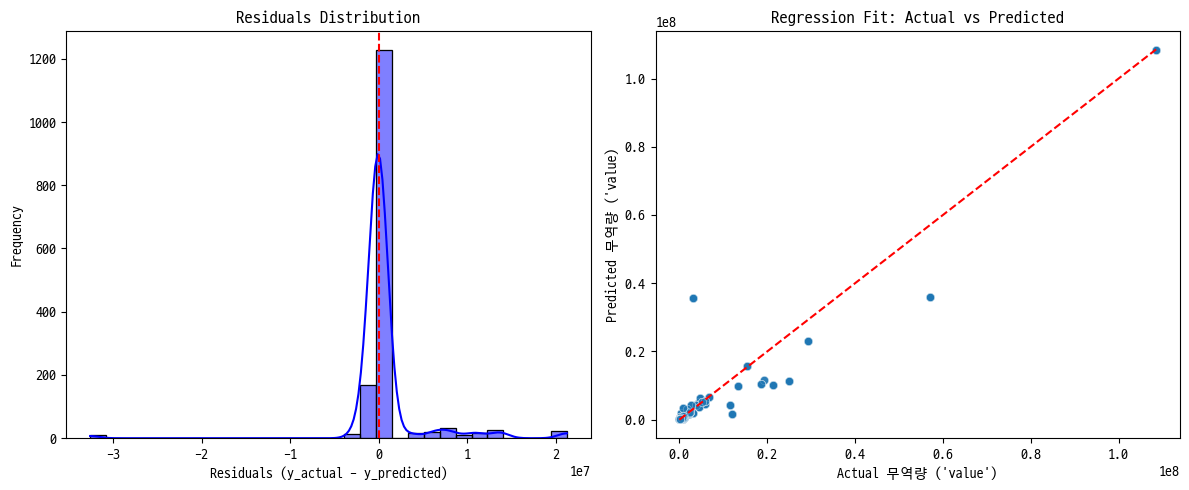

In [65]:
y_actual = y_true['value']
y_predicted = y_pred['value']

# Compute residuals.
residuals = y_actual - y_predicted


# Create plots.
plt.figure(figsize=(12,5))


# Plot 1: Residuals Distribution.
plt.subplot(1,2,1)
sns.histplot(residuals, bins=30, kde=True, color="blue")
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Residuals Distribution")
plt.xlabel("Residuals (y_actual - y_predicted)")
plt.ylabel("Frequency")


# Plot 2: Regression Fit (Actual vs Predicted).
plt.subplot(1,2,2)
sns.scatterplot(x=y_actual, y=y_predicted, alpha=0.5)
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle='--')  # Perfect fit line
plt.title("Regression Fit: Actual vs Predicted")
plt.xlabel("Actual 무역량 ('value')")
plt.ylabel("Predicted 무역량 ('value)")


# Show plots.
plt.tight_layout()
plt.show()

In [77]:
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate,
    plot_rank,
    plot_slice
)

In [ ]:
# ! pip install nbformat -q

In [71]:
import nbformat
nbformat.__version__

'5.10.4'

In [81]:
import plotly.io as pio
#pio.renderers.default = "vscode"  # VS Code 내부 출력 (요즘 가장 안정적)
# 또는
pio.renderers.default = "browser"  # 브라우저 출력

In [82]:
plot_optimization_history(study)

Opening in existing browser session.


In [83]:
plot_param_importances(study)

Opening in existing browser session.


In [84]:
plot_parallel_coordinate(study)

Opening in existing browser session.


In [85]:
plot_rank(study)

Opening in existing browser session.


In [86]:
plot_slice(study)


Opening in existing browser session.


## 7. 제출 파일 만들기
- pivot을 train, test로 split했던 것을 다시 합쳐서 Feat. Eng. 한 것 추가하고 재학습하여 최종 제출 파일을 만든다. 

In [87]:
# 1) 공햏성쌍 탐색 함수 파라미터 세팅 (default: min_lag=1, max_lag=6, min_nonzero=12, corr_threshold=0.4)
min_lag=1
max_lag=6 
min_nonzero=12 
corr_threshold=0.4

# 설정파라미터 로깅
#EXP_LOG = {} # 테스트 파라미터 값 저장 딕셔너리 ==> 일단 이건 고정하고, feat.eng.와 model에 변화주며 테스팅
EXP_LOG['min_lag'] = 1
EXP_LOG['max_lag'] = 6
EXP_LOG['min_nonzero'] = 12
EXP_LOG['corr_threshold'] = 0.4

# 2) LinearRegression 모델 파라미터 세팅(defaut: )

# 3) pivot 데이터프레임
pivot = pivot_org.copy()
print("pivot.shape: ", pivot.shape)
pivot.head(3)

pivot.shape:  (100, 43)


ym,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,...,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,14276.0,52347.0,53549.0,0.0,26997.0,84489.0,0.0,0.0,0.0,0.0,...,428725.0,144248.0,26507.0,25691.0,25805.0,0.0,38441.0,0.0,441275.0,533478.0
AHMDUILJ,242705.0,120847.0,197317.0,126142.0,71730.0,149138.0,186617.0,169995.0,140547.0,89292.0,...,123085.0,143451.0,78649.0,125098.0,80404.0,157401.0,115509.0,127473.0,89479.0,101317.0
ANWUJOKX,0.0,0.0,0.0,63580.0,81670.0,26424.0,8470.0,0.0,0.0,80475.0,...,0.0,0.0,0.0,27980.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
# 4) 공행성쌍 with pivot_org
pairs = find_comovement_pairs_diff(pivot_org, max_lag, min_nonzero, corr_threshold) # pivot_org로 한것은 default pairs를 유지하기위함
print("탐색된 공행성쌍 수:", len(pairs)) # 탐색된 공행성쌍 수: 1425 -> 

EXP_LOG["탐색된 공행성쌍 pairs.shape"] = pairs.shape
#pairs.head()

#####
##### Feature. Eng.
#####
# Engineered Feature 를 pairs에 추가:  위에서 feat. eng. 한 범주화 변수 추가 ()
pairs['wv_cat'] = pairs['following_item_id'].map(dct_wv_cat) # following_item_id 에 대한 추론을 할 것이므로
pairs.head(3)

# Engineered Feature 를 pairs에 추가:  위에서 feat. eng. 한 범주화 변수 추가 ()
pairs['seq_cat'] = pairs['following_item_id'].map(dct_seq_cat) # following_item_id 에 대한 추론을 할 것이므로
pairs.head(3)

# Engineered Feature 를 pairs에 추가:  위에서 feat. eng. 한 범주화 변수 추가 ()
pairs['hs4_cat'] = pairs['following_item_id'].map(dct_hs4_cat) # following_item_id 에 대한 추론을 할 것이므로
pairs.head(3)

100it [00:07, 12.76it/s]

탐색된 공행성쌍 수: 1562


,leading_item_id,following_item_id,best_lag,max_corr,wv_cat,seq_cat,hs4_cat
0,AANGBULD,APQGTRMF,6,0.417464,4,3,14
1,AANGBULD,BJALXPFS,6,0.524327,4,3,14
2,AANGBULD,DEWLVASR,6,0.483517,4,3,14


In [89]:
# 5) 학습 데이터 생성
df_train_model = build_training_data_fe(pivot_org, pairs, add_fe=['wv_cat', 'seq_cat', 'hs4_cat']) # 생성된 학습 데이터의 shape : (53318, 7) ->  (54743, 8) ->  (54743, 9)
print('생성된 학습 데이터의 shape :', df_train_model.shape)
display(df_train_model.head())
EXP_LOG['생성된 학습 데이터의 shape'] = df_train_model.shape

생성된 학습 데이터의 shape : (59953, 9)


,b_t,b_t_1,a_t_lag,max_corr,best_lag,wv_cat,seq_cat,hs4_cat,target
0,759980.0,582317.0,14276.0,0.417464,6.0,4.0,3.0,14.0,216019.0
1,216019.0,759980.0,52347.0,0.417464,6.0,4.0,3.0,14.0,537693.0
2,537693.0,216019.0,53549.0,0.417464,6.0,4.0,3.0,14.0,205326.0
3,205326.0,537693.0,0.0,0.417464,6.0,4.0,3.0,14.0,169440.0
4,169440.0,205326.0,26997.0,0.417464,6.0,4.0,3.0,14.0,698033.0


In [90]:
params_optuna

{'max_depth': 19,
 'learning_rate': 0.004759433844819988,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_features': 2,
 'n_estimators': 1444,
 'random_state': 42}

In [92]:
# 6) 회귀모델 학습
#feature_cols = ['b_t', 'b_t_1', 'a_t_lag', 'max_corr', 'best_lag']
#feature_cols = ['b_t', 'b_t_1', 'a_t_lag', 'max_corr', 'best_lag', 'wv_cat']
#feature_cols = ['b_t', 'b_t_1', 'a_t_lag', 'max_corr', 'best_lag', 'wv_cat', 'seq_cat']
feature_cols = ['b_t', 'b_t_1', 'a_t_lag', 'max_corr', 'best_lag', 'wv_cat', 'seq_cat', 'hs4_cat']

train_X = df_train_model[feature_cols].values
train_y = df_train_model["target"].values

#mdl = LinearRegression()
reg = ensemble.GradientBoostingRegressor()
 
reg.set_params(**params_optuna)
reg.fit(train_X, train_y)

,loss,'squared_error'
,learning_rate,0.004759433844819988
,n_estimators,1444
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,4
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_depth,19
,min_impurity_decrease,0.0
,init,None


In [93]:
# 7) 모델 추론
#y_pred = predict(pivot, pairs, reg)
#_pred = predict_fe(pivot, pairs, reg, add_fe=['wv_cat', 'seq_cat'])
y_pred = predict_fe(pivot, pairs, reg, add_fe=['wv_cat', 'seq_cat', 'hs4_cat'])

print("pivot.shape: ", pivot.shape) # (100, 42) -> (100, 43)
display(pivot.head(3))
print("pairs.shape: ", pairs.shape) # (1425, 4) -> (1425, 5)  -> (1425, 6)  -> (1425, 7)
display(pairs.head(3))
print("y_pred.shape: ", y_pred.shape) # y_pred.shape:  (1425, 3)
display(y_pred.head(3))

1562it [00:05, 296.70it/s]


pivot.shape:  (100, 43)


ym,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,...,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,14276.0,52347.0,53549.0,0.0,26997.0,84489.0,0.0,0.0,0.0,0.0,...,428725.0,144248.0,26507.0,25691.0,25805.0,0.0,38441.0,0.0,441275.0,533478.0
AHMDUILJ,242705.0,120847.0,197317.0,126142.0,71730.0,149138.0,186617.0,169995.0,140547.0,89292.0,...,123085.0,143451.0,78649.0,125098.0,80404.0,157401.0,115509.0,127473.0,89479.0,101317.0
ANWUJOKX,0.0,0.0,0.0,63580.0,81670.0,26424.0,8470.0,0.0,0.0,80475.0,...,0.0,0.0,0.0,27980.0,0.0,0.0,0.0,0.0,0.0,0.0


pairs.shape:  (1562, 7)


,leading_item_id,following_item_id,best_lag,max_corr,wv_cat,seq_cat,hs4_cat
0,AANGBULD,APQGTRMF,6,0.417464,4,3,14
1,AANGBULD,BJALXPFS,6,0.524327,4,3,14
2,AANGBULD,DEWLVASR,6,0.483517,4,3,14


y_pred.shape:  (1562, 3)


,leading_item_id,following_item_id,value
0,AANGBULD,APQGTRMF,117971
1,AANGBULD,BJALXPFS,205451
2,AANGBULD,DEWLVASR,264140


In [94]:
y_pred.groupby("following_item_id")['value'].agg(['size', 'max', 'min', 'mean', 'median', 'var', 'std']).iloc[0:20]

,size,max,min,mean,median,var,std
following_item_id,,,,,,,
AANGBULD,12,336171,239867,2.857862e+05,286442.0,9.607537e+08,3.099603e+04
AHMDUILJ,22,126196,90015,1.098409e+05,110383.5,9.458392e+07,9.725427e+03
APQGTRMF,19,160868,105909,1.283727e+05,126177.0,1.519216e+08,1.232565e+04
ATLDMDBO,22,43493889,35838494,3.935224e+07,39375819.0,3.958758e+12,1.989663e+06
AXULOHBQ,14,108277,72710,8.846100e+04,88272.5,9.151793e+07,9.566500e+03
BEZYMBBT,18,4047412,3426045,3.594223e+06,3546575.0,2.878685e+10,1.696669e+05
BJALXPFS,22,215508,166596,1.866583e+05,185204.0,1.257119e+08,1.121213e+04
BLANHGYY,23,37831,20614,2.887370e+04,29964.0,2.113841e+07,4.597653e+03
BSRMSVTC,27,402334,278239,3.353253e+05,335117.0,1.010856e+09,3.179396e+04


In [95]:
# 로깅한 주요파라미터들 
#print(f"EXP_LOG: {EXP_LOG}")

for k,v in EXP_LOG.items():
    print(f'{k} : {v}')

min_lag : 1
max_lag : 6
min_nonzero : 12
corr_threshold : 0.4
탐색된 공행성쌍 pairs.shape : (1562, 4)
공행성이 탐지되지 않은 상품수 : 9
공행성이 탐지되지 않은 상품id: : ['ANWUJOKX', 'GIKPEWTY', 'GMBFCMIU', 'KFQSHBNH', 'PLMZALFA', 'QSDCUCLB', 'RJCAXSGH', 'RUVXNNVA', 'TANNMIMB']
공행성이 탐지된 상품수 : 91
생성된 학습 데이터의 shape : (59953, 9)
local_exp_score : 0.7682049856764146
optuna Best Study : FrozenTrial(number=1, state=<TrialState.COMPLETE: 1>, values=[0.8073699832877662], datetime_start=datetime.datetime(2025, 11, 22, 19, 12, 34, 16518), datetime_complete=datetime.datetime(2025, 11, 22, 19, 15, 49, 737794), params={'gbt_max_depth': 19, 'gbt_learning_rate': 0.004759433844819988, 'gbt_max_features': 2, 'gbt_min_samples_split': 4, 'gbt_min_samples_leaf': 2, 'gbt_n_estimators': 1444}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'gbt_max_depth': IntDistribution(high=32, log=True, low=2, step=1), 'gbt_learning_rate': FloatDistribution(high=1.0, log=True, low=0.001, step=None), 'gbt_max_features': IntDistri

In [96]:
# submit csv 생성
#save_file_name = '../data/local_test_LR_FE_wv_seq_hs4_20251117_pyy.csv'
#save_file_name = '../data/local_env_v05_sklearn_gbt_optuna_20251121_pyy.csv'
save_file_name = '../data/local_env_v06_sklearn_gbt_optuna_diff_20251122_pyy.csv'

submission_submit = y_pred.copy()
submission_submit.to_csv(save_file_name, index=False)